In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lombscargle
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.stattools import acf
from arch import arch_model
from statsmodels.tsa.seasonal import STL
from scipy.stats import boxcox
from scipy.stats import boxcox_normmax
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

colours = {
    'cucumbers': '#4daf4a', # Green
    'guitars': '#f781bf',      # Pink
    'slingshots': '#984ea3',  # Purple
    'stocks': '#e41a1c',  # Red
    'sugar': '#ff7f00',      # Orange
    'water': '#377eb8',    # Blue
    'tranquillity': '#a65628' # Brown
}

# Load and Clean Data
df = pd.read_csv("spiff_data.csv")
df = df.dropna(how='all', axis=1).dropna(how='all', axis=0)
df.replace(1000, np.nan, inplace=True)
df=df.drop(columns='Unnamed: 0')
df.rename(columns={'gurkor':'cucumbers'}, inplace=True)
# Save the cleaned dataframe to a new CSV file
df.to_csv('spiff_data_cleaned.csv', index=False)

# Compute Log Returns
log_returns = np.log(df.drop(columns='day') / df.drop(columns='day').shift(1))
log_returns['day'] = df['day']

In [2]:
df.head()

,day,cucumbers,guitars,slingshots,stocks,sugar,water,tranquillity
0,1.0,6.154653,2.794285,2.136536,10.653684,3.324896,3.896149,7.755880
1,2.0,6.189623,2.843068,2.113582,10.674465,3.355736,3.899915,7.781310
2,3.0,6.168641,2.839644,2.116336,10.822372,3.336461,3.897404,7.886205
3,4.0,6.156401,2.823384,2.096137,10.848804,3.288274,3.901170,7.848061
4,5.0,6.124929,2.832798,2.099810,10.860731,3.303694,3.905355,7.883026


In [3]:
summary_stats = df.describe()
summary_stats

,day,cucumbers,guitars,slingshots,stocks,sugar,water,tranquillity
count,5455.000000,5201.000000,5201.000000,5201.000000,5201.000000,5201.000000,5201.000000,5201.000000
mean,2728.816865,8.934701,5.758999,3.562496,6.354767,2.663530,5.794586,11.552924
std,1575.126349,2.268289,1.756993,0.973406,2.139400,0.727010,1.275024,3.067634
min,1.000000,5.942896,2.629048,2.001362,4.012346,1.370262,3.739412,6.614749
25%,1365.500000,6.947150,4.252728,2.804869,4.916920,1.999030,4.996563,9.186268
50%,2729.000000,8.905505,5.907840,3.383130,5.520531,2.605522,5.774852,10.584870
75%,4092.500000,10.183919,7.055568,4.291411,6.946382,3.279982,6.488217,13.380483
max,5456.000000,14.132395,10.719387,6.468982,13.613052,4.125193,8.949187,21.137953


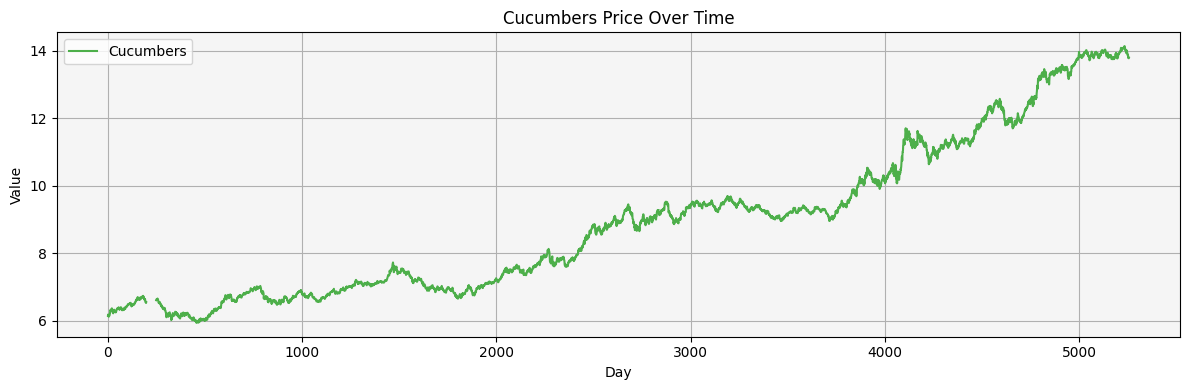

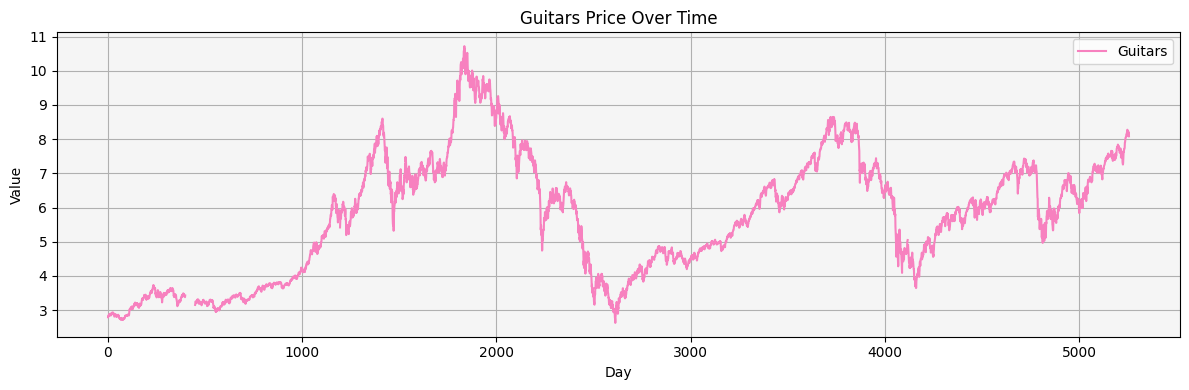

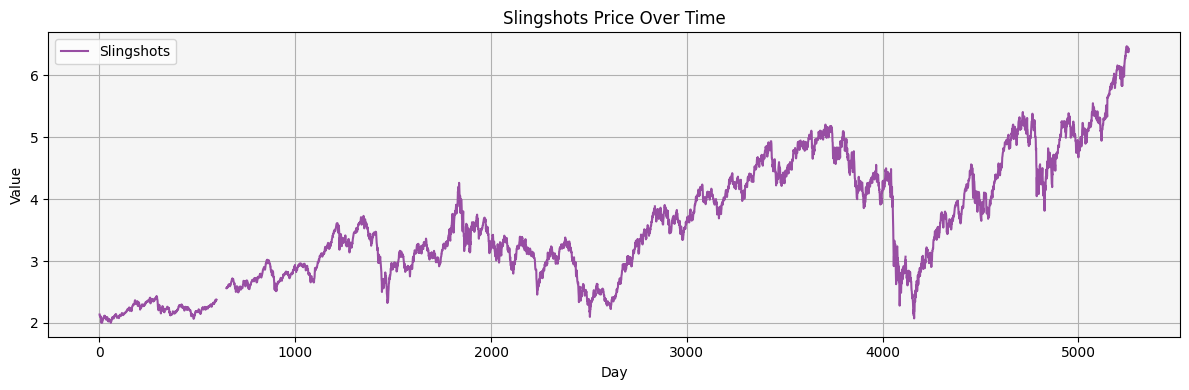

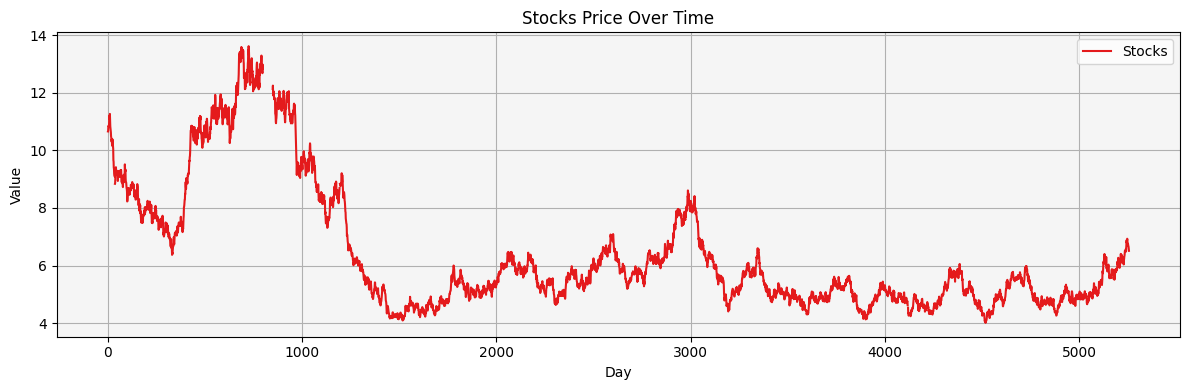

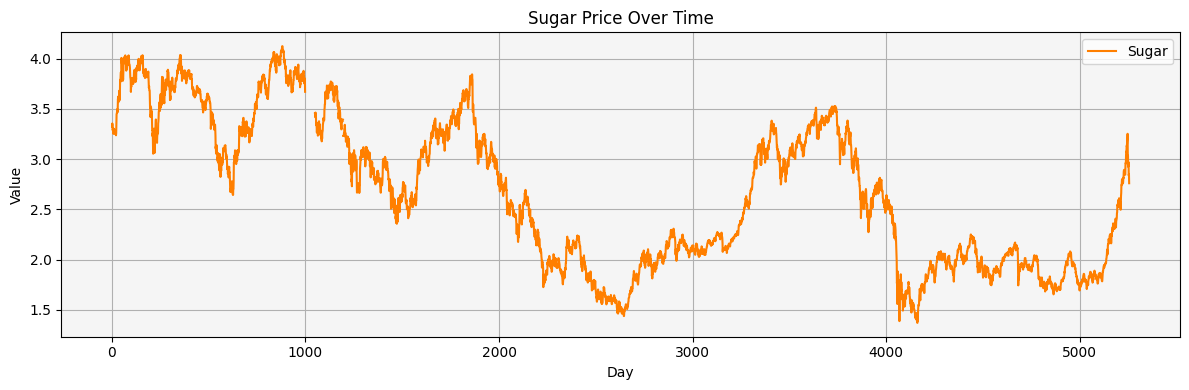

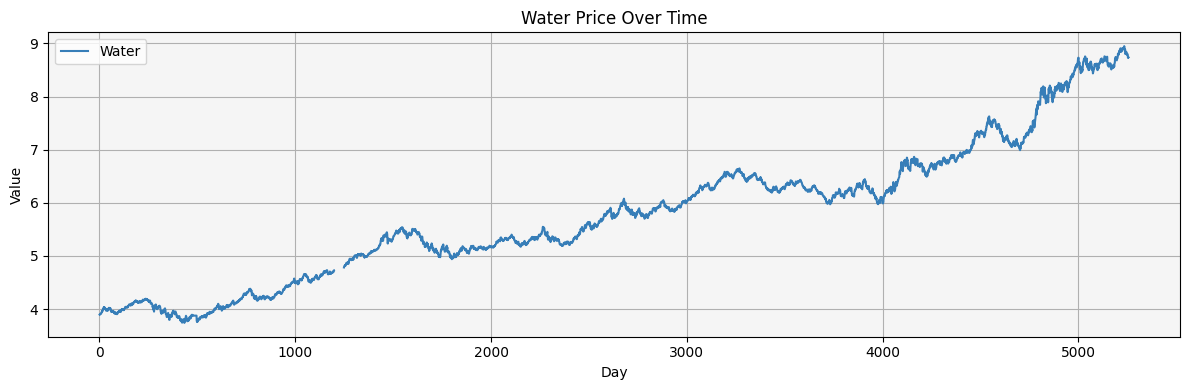

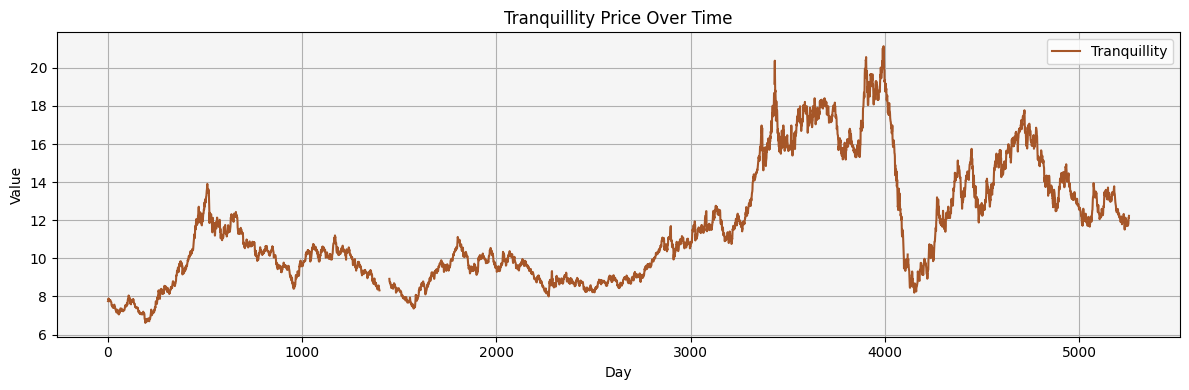

In [4]:
# Create a separate plot for each column
for column, color in colours.items():
    plt.figure(figsize=(12, 4))
    plt.plot(df['day'], df[column], color=color, label=column.capitalize())
    plt.title(f'{column.capitalize()} Price Over Time')
    plt.xlabel('Day')
    plt.ylabel('Value')
    plt.grid(True)
    plt.gca().set_facecolor("whitesmoke")
    plt.legend()
    plt.tight_layout()
    plt.show()

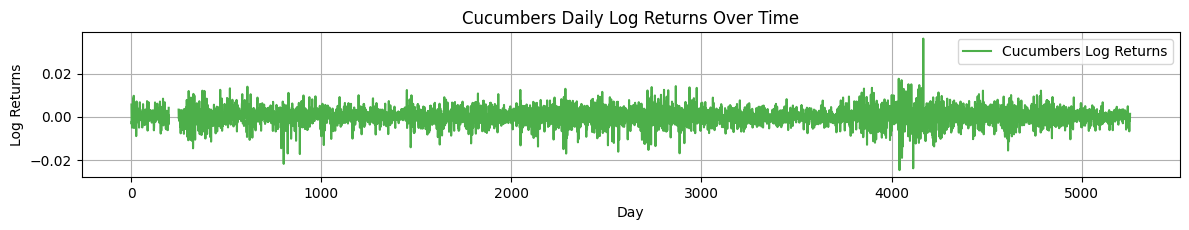

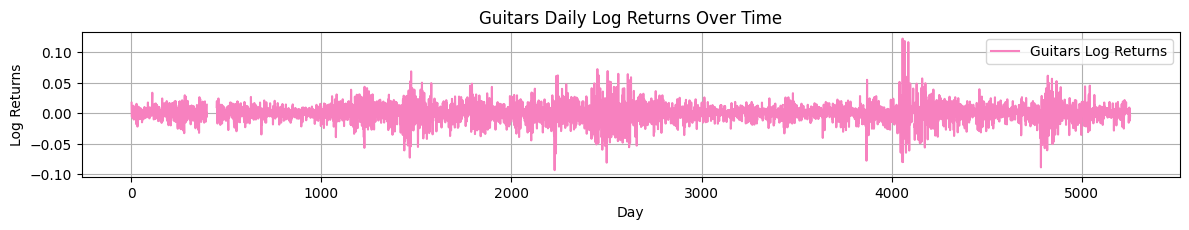

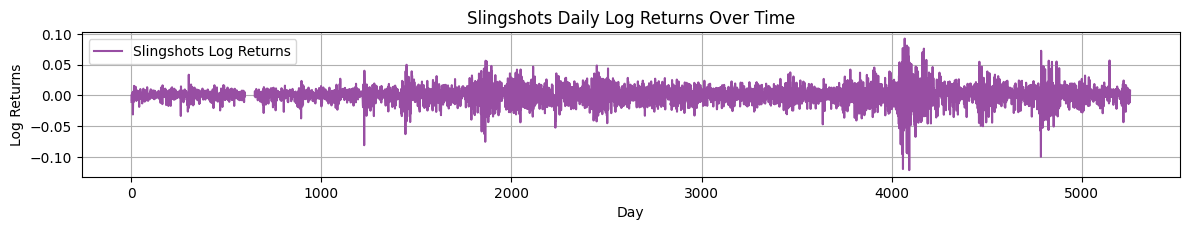

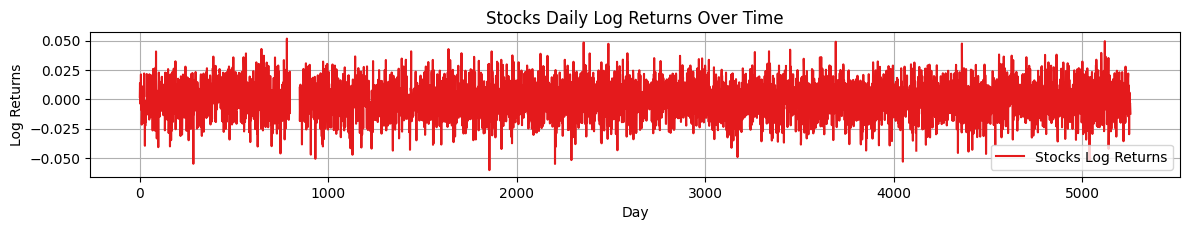

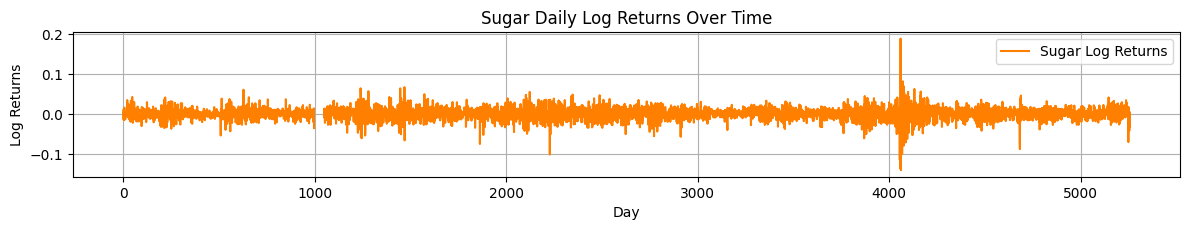

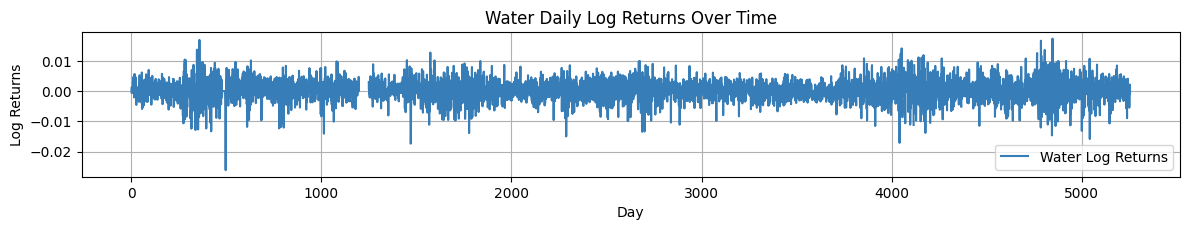

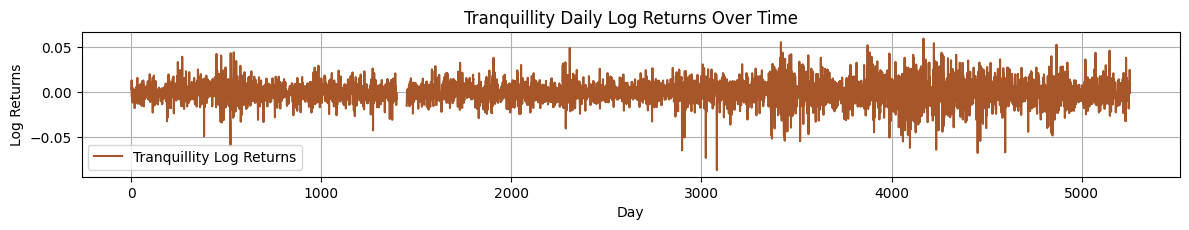

In [5]:
# Loop through each column for plotting
for column, color in colours.items():
    plt.figure(figsize=(12, 4))
    # Plot log returns
    plt.subplot(2, 1, 2)
    plt.plot(log_returns[column], color=color, label=f'{column.capitalize()} Log Returns')
    plt.title(f'{column.capitalize()} Daily Log Returns Over Time')
    plt.xlabel('Day')
    plt.ylabel('Log Returns')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

Correlation Matrix Raw data

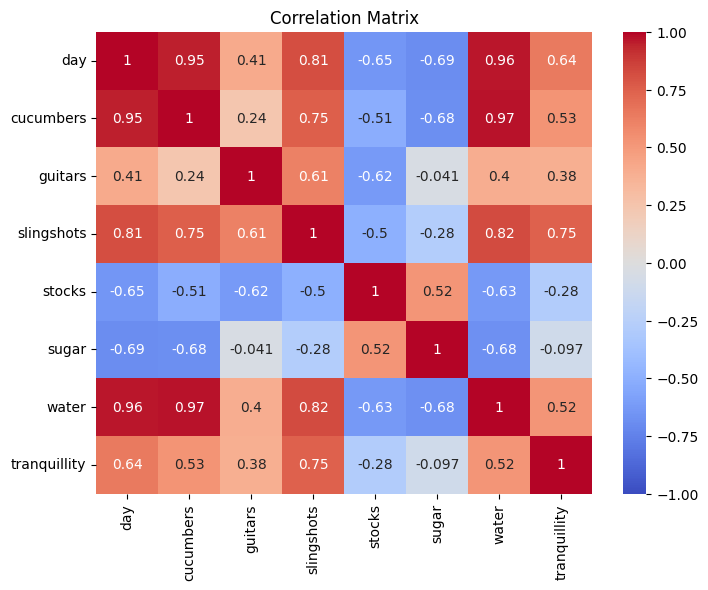

In [6]:
corr = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

Correlation Matrix log-returns data

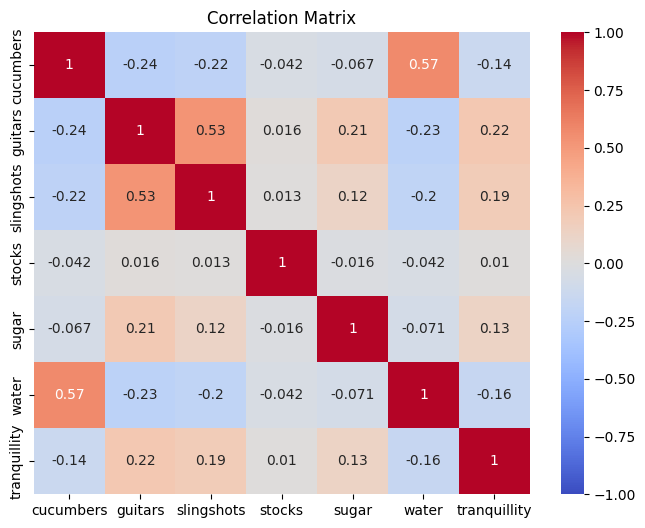

In [7]:
df=df.dropna()
plt.figure(figsize=(8,6))
sns.heatmap(log_returns.drop(columns='day').corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

Strongest correlation (full series):
              cucumbers   guitars  slingshots    stocks     sugar     water  \
cucumbers      1.000000 -0.241075   -0.216712 -0.041636 -0.133521  0.573293   
guitars       -0.241075  1.000000    0.526253 -0.038285  0.360918 -0.226021   
slingshots    -0.216712  0.526253    1.000000  0.055963  0.391195 -0.201113   
stocks         0.042655 -0.045073    0.036741  1.000000  0.035972 -0.046830   
sugar         -0.066739  0.211811    0.118452 -0.054133  1.000000 -0.071434   
water          0.573293 -0.226021   -0.201113  0.054034 -0.136810  1.000000   
tranquillity  -0.137819  0.223933    0.188563  0.044228  0.126743 -0.157992   
day            0.014139 -0.010040    0.005257  0.014199  0.010833  0.010080   

              tranquillity       day  
cucumbers        -0.137819  0.010644  
guitars           0.223933 -0.008460  
slingshots        0.188563  0.005486  
stocks            0.032200  0.013399  
sugar             0.126743  0.006795  
water            

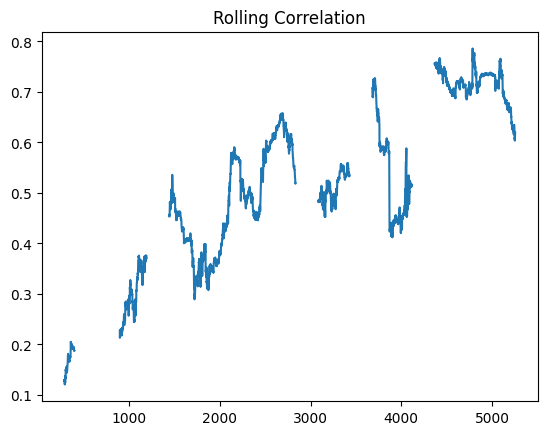

In [27]:
def crosscorr(a, b, lag=0):
    # Cross correlation between two series
    # Skips the calculation if not enough datapoints

    b_shifted = b.shift(lag)
    valid = a.notna() & b_shifted.notna()
    a_valid = a[valid]
    b_valid = b_shifted[valid]

    if len(a_valid) < 2:
        return np.nan
    if a_valid.std() == 0 or b_valid.std() == 0:
        return np.nan

    return a_valid.corr(b_valid)


def lag_ccf(data,series, max_lag = 100):
    # Get cross correlation up to max_lag (for one series only)

    labels = data.columns.values

    ccf = pd.DataFrame() # ccf = cross correlation function
    for label in labels:
        correlation = np.zeros(max_lag)
        for h in range(max_lag):
            correlation[h] = crosscorr(data[series],data[label],lag=h)

        ccf.insert(len(ccf.columns),label, correlation)

    return ccf


def strongest_corr(data):
    # Function to calculate cross correlation with lag
    # Returns:
    # strongest_ccf : strongest pairwise cross correlation between series
    # strongest_lag : lag at which the strongest correlation occurs

    labels = data.columns.values

    strongest_ccf = pd.DataFrame()
    strongest_lag = pd.DataFrame()

    for label in labels:
        ccf = lag_ccf(data,label)

        strongest_vals = pd.Series(index=ccf.columns)
        strongest_indices = pd.Series(index=ccf.columns)

        for col in ccf.columns:
            col_series = ccf[col]
            abs_col_series = col_series.abs()
            idx = abs_col_series.idxmax()
            strongest_indices[col] = idx
            strongest_vals[col] = col_series.loc[idx]

        strongest_ccf = pd.concat([strongest_ccf,strongest_vals],axis=1)
        strongest_lag = pd.concat([strongest_lag,strongest_indices],axis=1)

    strongest_ccf.columns = labels
    strongest_lag.columns = labels
    return strongest_ccf,strongest_lag


# Testing rolling correlation to see if it varies with time
rolling_corr = log_returns['guitars'].rolling(250).corr(log_returns['slingshots'])
rolling_corr.plot(title='Rolling Correlation')
#plt.show()

# Manually selected stable vs volatile periods (from visual analysis of returns)
volatile = log_returns[4000:4200]
stable = log_returns[0:3500]

strongest_ccf_full,strongest_lag_full = strongest_corr(log_returns)
strongest_ccf_volatile,strongest_lag_volatile = strongest_corr(volatile)
strongest_ccf_stable,strongest_lag_stable = strongest_corr(stable)

# Print results
print('Strongest correlation (full series):')
print(strongest_ccf_full)
print('Lag at which strongest correlation occurs (full):')
print(strongest_lag_full)

print('Strongest correlation (stable period):')
print(strongest_ccf_stable)
print('Lag at which strongest correlation occurs (stable):')
print(strongest_lag_stable)

print('Strongest correlation (volatile period):')
print(strongest_ccf_volatile)
print('Lag at which strongest correlation occurs (volatile):')
print(strongest_lag_volatile)

ACF for log-returnes

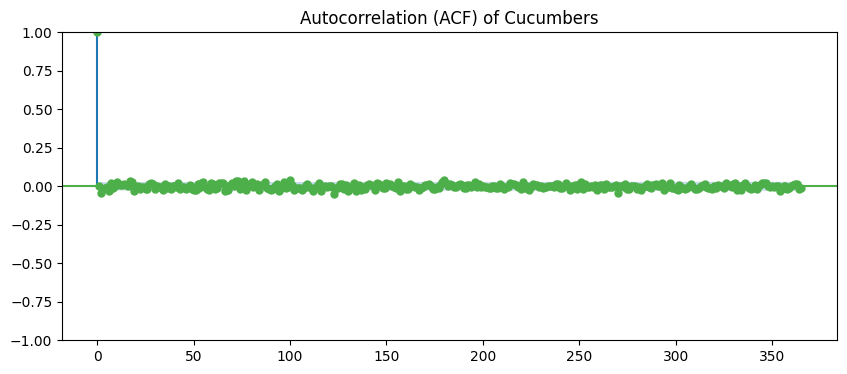

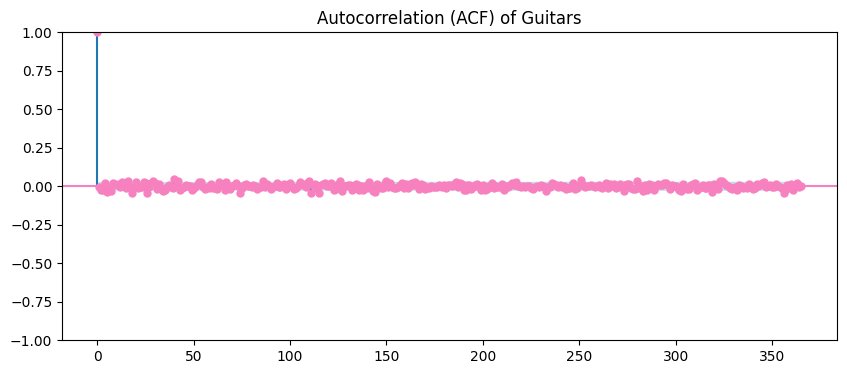

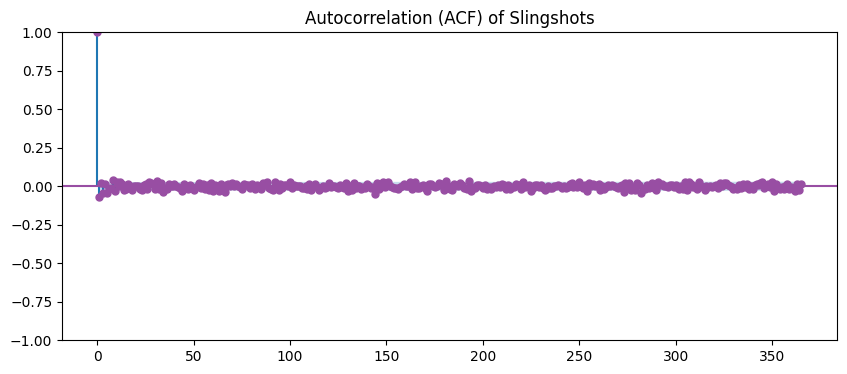

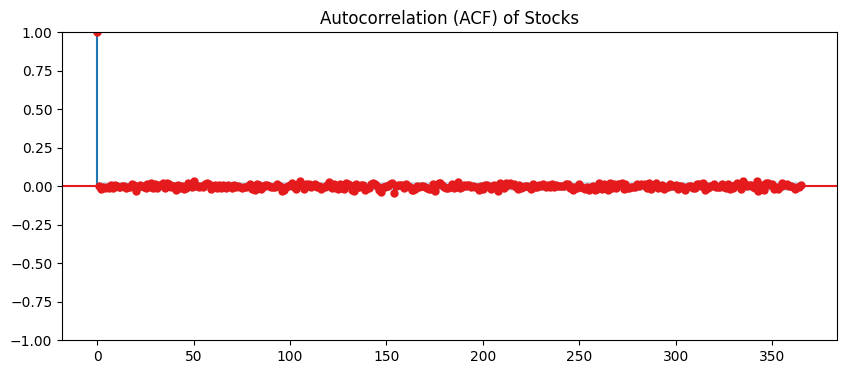

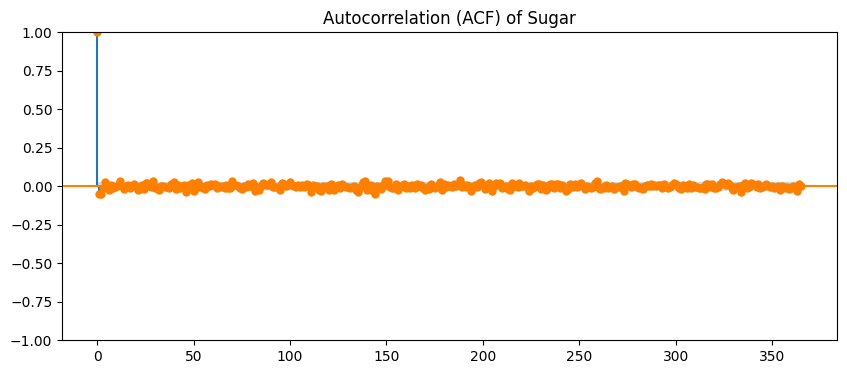

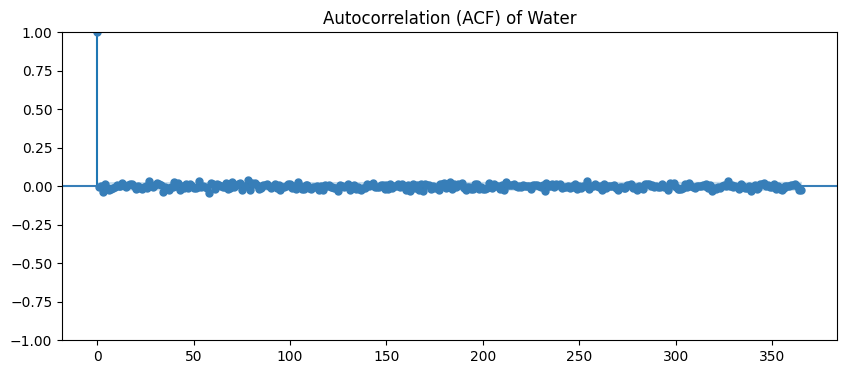

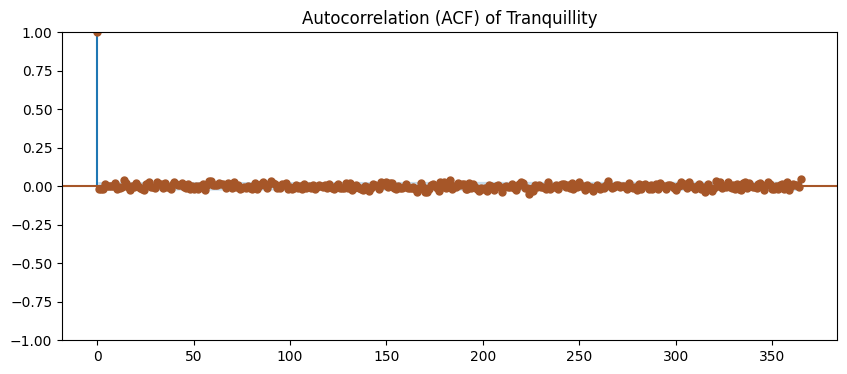

In [8]:
for column, color in colours.items():
    series = log_returns[column].dropna()
    fig, ax = plt.subplots(figsize=(10, 4))
    plot_acf(series, ax=ax, lags=365, alpha=0.05, color=color)
    ax.set_title(f'Autocorrelation (ACF) of {column.capitalize()}')
    plt.show()


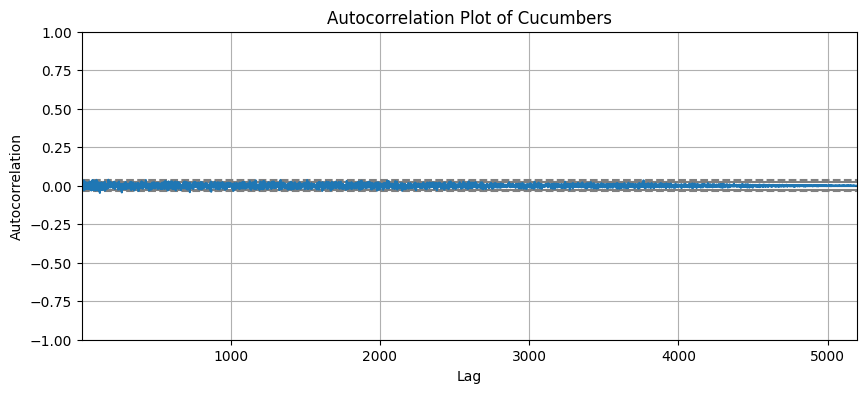

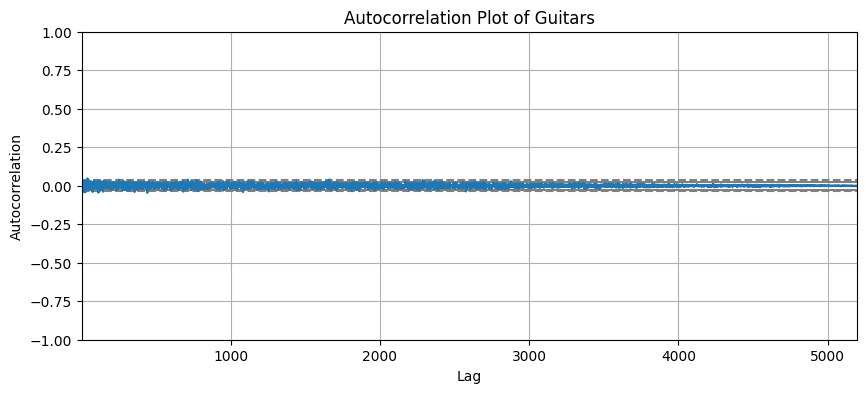

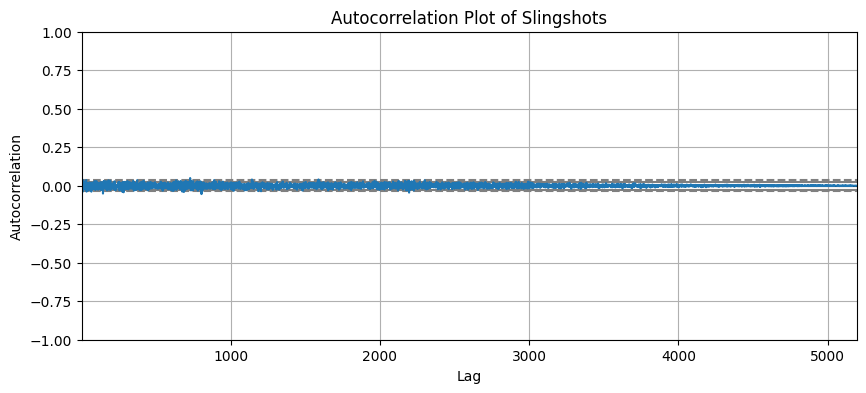

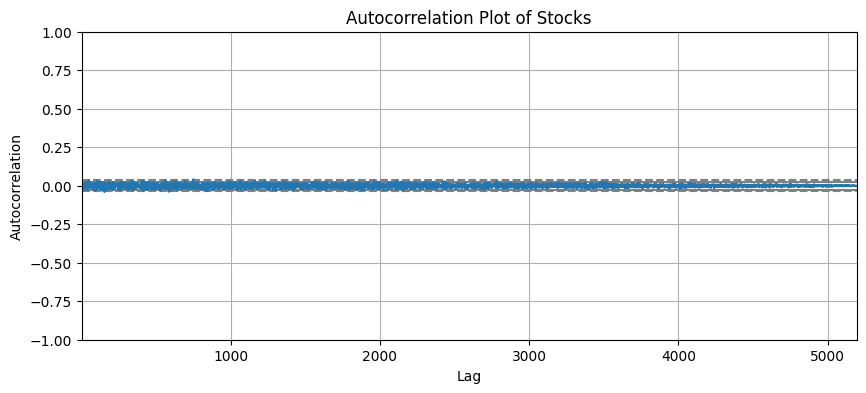

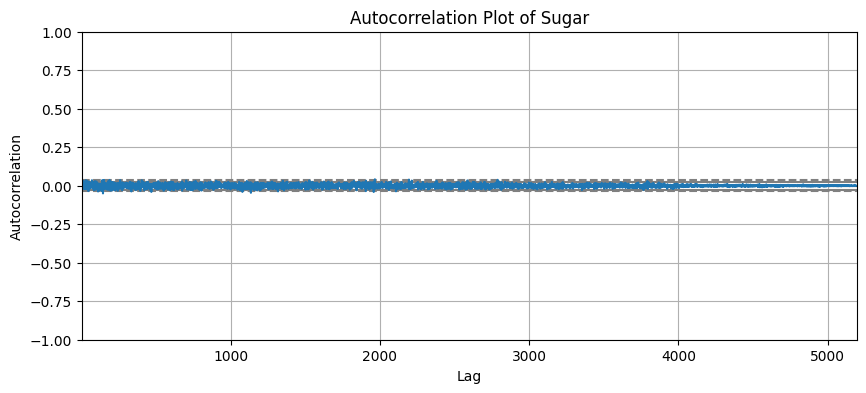

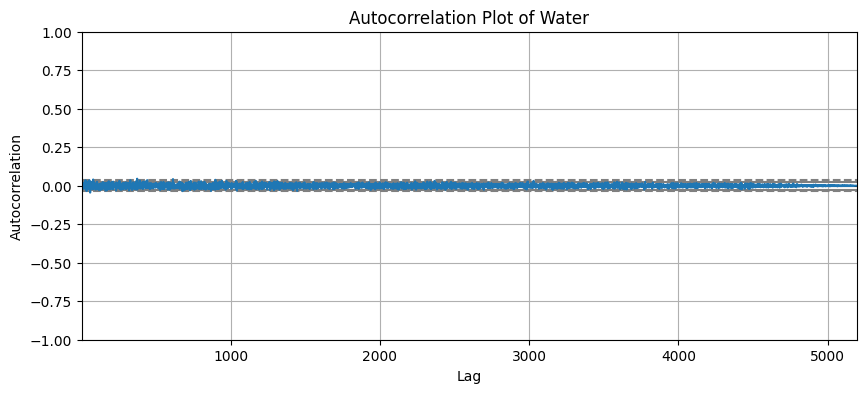

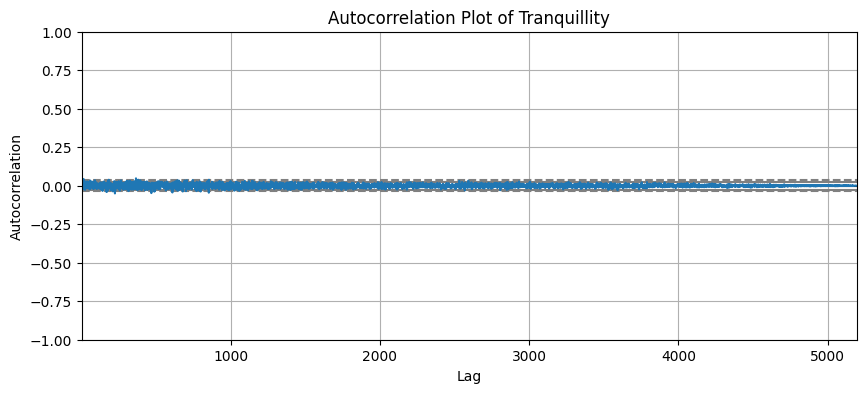

In [9]:
from pandas.plotting import autocorrelation_plot

for column, color in colours.items():
    series = log_returns[column].dropna()
    plt.figure(figsize=(10,4))
    autocorrelation_plot(series)
    plt.title(f'Autocorrelation Plot of {column.capitalize()}')
    plt.show()


Trying to fins a seasonal lag 

In [10]:
# Function to find the best seasonal lag based on the highest significant autocorrelation peak
def best_seasonal_lag(series, max_lag=365):
    acf_values, confint = acf(series, nlags=max_lag, alpha=0.05)
    # Ignore lag 0 and find the lag with the highest autocorrelation above confidence interval
    significant_lags = [(lag, val) for lag, val in enumerate(acf_values[1:], 1) if val > confint[lag][1]]
    if significant_lags:
        best_lag = max(significant_lags, key=lambda x: x[1])[0]
        return best_lag
    else:
        return None

# Find best seasonal lag for each time series
best_lags = {}
max_lag_to_check = 365*7
for col in df.columns:
    lag = best_seasonal_lag(log_returns[f'{col}'], max_lag=max_lag_to_check)
    best_lags[col] = lag

best_lags

{'day': None,
 'cucumbers': None,
 'guitars': None,
 'slingshots': None,
 'stocks': None,
 'sugar': None,
 'water': None,
 'tranquillity': None}

Stl helper fuctions

In [11]:
def calculate_seasonality_strength(result):
    """Strength = variance of seasonal / (variance of seasonal + variance of residual)"""
    seasonal_var = np.var(result.seasonal)
    residual_var = np.var(result.resid)
    return seasonal_var / (seasonal_var + residual_var)

def best_fixed_period(series, periods_to_test):
    """Find best period among a fixed set."""
    best_strength = -np.inf
    best_period = None
    
    for test_period in periods_to_test:
        if test_period >= len(series.dropna()) // 2:
            continue  # Skip if period is too long for data

        try:
            stl = STL(series, period=test_period, robust=True)
            result = stl.fit()
            strength = calculate_seasonality_strength(result)
            print(f"Tested Period {test_period} days: Strength = {strength:.3f}")
            
            if strength > best_strength:
                best_strength = strength
                best_period = test_period
        except Exception as e:
            print(f"Error testing period {test_period}: {e}")
            continue

    return best_period, best_strength

# Define function for adaptive cutoff
def adaptive_cutoff(periods):
    """
    Compute adaptive cutoff based on period length.
    Cutoff dynamically adjusts based on logarithmic scaling.
    """
    C0 = 0.2  # Base threshold for short periods
    lambda_factor = 0.05  # Scaling effect for longer periods
    return C0 + lambda_factor * np.log(periods)

Box-Cox transformation with Guerrero method

In [12]:
# --- Guerrero lambda estimation ---
def guerrero_lambda(series, period=12):
    """Approximate Guerrero method for Box-Cox lambda selection."""
    series = series.dropna()
    rolling_var = series.rolling(window=period, center=True, min_periods=1).var()
    mean_var_ratio = rolling_var.mean() / series.var()
    return max(-2, min(2, np.log(mean_var_ratio)))

# Containers
mle_transformed = {}
guerrero_transformed = {}
lambda_results = []

# Process each column
for col in df.columns:
    if col == 'day':
        continue
    series = df[col].dropna()

    if (series <= 0).any():
        print(f"Skipping {col} (contains non-positive values)")
        continue

    try:
        # Box-Cox MLE
        lambda_mle = boxcox_normmax(series, method='mle')
        transformed_mle = boxcox(series, lmbda=lambda_mle)

        # Guerrero lambda
        lambda_guerrero = guerrero_lambda(series)
        transformed_guerrero = boxcox(series, lmbda=lambda_guerrero)

        # Store
        mle_transformed[col] = transformed_mle
        guerrero_transformed[col] = transformed_guerrero
        lambda_results.append({
            "Instrument": col,
            "BoxCox_MLE_Lambda": round(lambda_mle, 6),
            "BoxCox_Guerrero_Lambda": round(lambda_guerrero, 6)
        })

        print(f"{col}: MLE λ = {lambda_mle:.4f}, Guerrero λ = {lambda_guerrero:.4f}")

    except Exception as e:
        print(f"Error processing {col}: {e}")

# Create result DataFrames
df_boxcox_mle = pd.DataFrame(mle_transformed)
df_boxcox_guerrero = pd.DataFrame(guerrero_transformed)
df_lambdas = pd.DataFrame(lambda_results)

cucumbers: MLE λ = -0.7630, Guerrero λ = -2.0000
guitars: MLE λ = 0.6651, Guerrero λ = -2.0000
slingshots: MLE λ = 0.1017, Guerrero λ = -2.0000
stocks: MLE λ = -2.2396, Guerrero λ = -2.0000
sugar: MLE λ = 0.0276, Guerrero λ = -2.0000
water: MLE λ = 0.1337, Guerrero λ = -2.0000
tranquillity: MLE λ = -0.8068, Guerrero λ = -2.0000


MA Heuristic-based window selection

In [13]:
def compute_optimal_window(series, window_range):
    global_mean = series.mean()
    N = len(series)
    results = []
 
    for w in window_range:
        # Centered moving average
        ma = series.rolling(window=w, center=True, min_periods=1).mean()
        valid_idx = ma.dropna().index
        if len(valid_idx) == 0:
            continue
        m_bar_w = ma.loc[valid_idx].mean()
 
        # D(w)
        D_w = abs(m_bar_w - global_mean)
 
        # E(w)
        E_terms = []
        for t in valid_idx:
            half = w // 2
            window_vals = series[max(0, t - half): min(N, t + half + 1)]
            if len(window_vals) >= 2:
                std = window_vals.std(ddof=1)
                se = std / np.sqrt(len(window_vals))
                E_terms.append(se)
        E_w = np.mean(E_terms) if E_terms else np.nan
 
        # S(w)
        S_w = D_w - E_w if not np.isnan(E_w) else np.nan
        results.append((w, D_w, E_w, S_w))
 
    df = pd.DataFrame(results, columns=["window", "D(w)", "E(w)", "S(w)"]).dropna()
    if df.empty:
        return None, None
    best_row = df.loc[df["S(w)"].idxmax()]
    return int(best_row["window"]), df

Seasonal strength on ma detrended data

In [14]:
# Heuristic-based window selection + detrending
detrended_df = pd.DataFrame(index=df.index)
optimal_windows = {}

# Apply to each transformed series
for col in df.columns:
    if col == 'day':
        continue
    print(f"Detrending {col}...")
    series = df[col].dropna()
    window_range = range(5, 365, 1)
 
    best_w, score_table = compute_optimal_window(series, window_range)
    if best_w is None:
        print(f"No valid window found for {col}.")
        continue
 
    trend = series.rolling(window=best_w, center=True, min_periods=1).mean()
    detrended = (series - trend).dropna()
 
    detrended_df[col] = detrended
    optimal_windows[col] = best_w
    print(f"Best window size for {col}: {best_w}")

Detrending cucumbers...
Best window size for cucumbers: 18
Detrending guitars...
Best window size for guitars: 64
Detrending slingshots...
Best window size for slingshots: 364
Detrending stocks...
Best window size for stocks: 363
Detrending sugar...
Best window size for sugar: 363
Detrending water...
Best window size for water: 12
Detrending tranquillity...
Best window size for tranquillity: 44


Instrument: cucumbers
Top 5 highest unique peaks (Period ≥ 2 days):
  Period = 608 days, Power = 0.0132
  Period = 822 days, Power = 0.0201
  Period = 988 days, Power = 0.0320
  Period = 1237 days, Power = 0.0462
  Period = 1713 days, Power = 0.0922



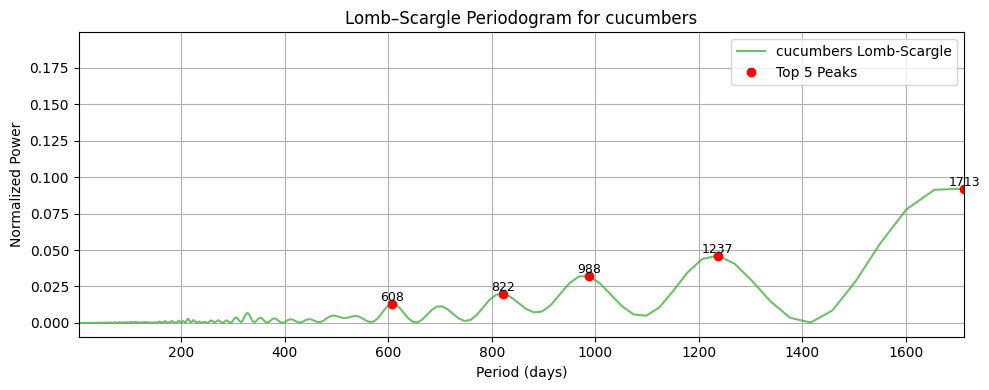

Instrument: guitars
Top 5 highest unique peaks (Period ≥ 2 days):
  Period = 541 days, Power = 0.0212
  Period = 631 days, Power = 0.0297
  Period = 759 days, Power = 0.0195
  Period = 881 days, Power = 0.0448
  Period = 1842 days, Power = 0.5279



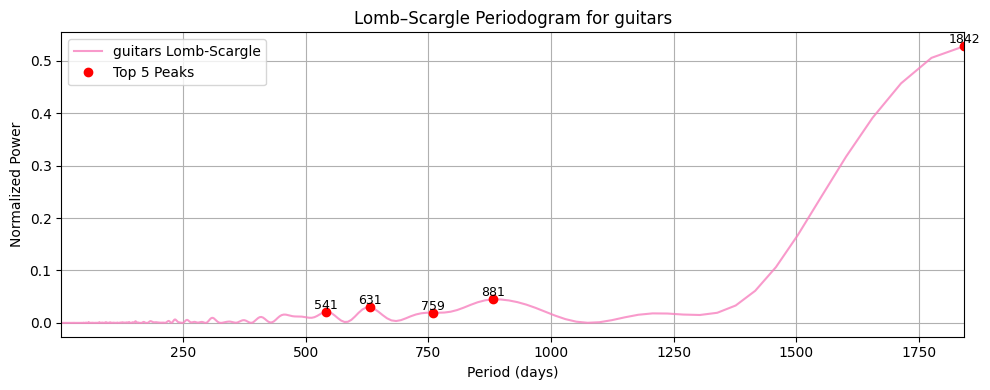

Instrument: slingshots
Top 5 highest unique peaks (Period ≥ 2 days):
  Period = 547 days, Power = 0.0217
  Period = 714 days, Power = 0.0271
  Period = 968 days, Power = 0.0346
  Period = 1237 days, Power = 0.0855
  Period = 1713 days, Power = 0.3489



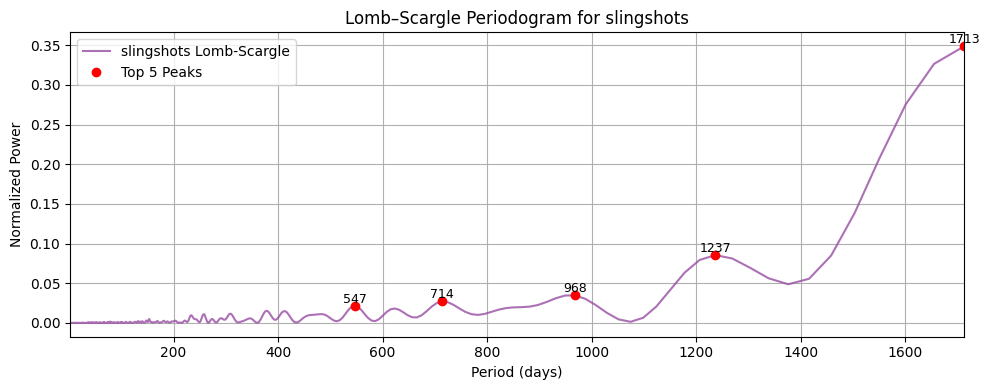

Instrument: stocks
Top 5 highest unique peaks (Period ≥ 2 days):
  Period = 431 days, Power = 0.0259
  Period = 704 days, Power = 0.0183
  Period = 897 days, Power = 0.0443
  Period = 1124 days, Power = 0.0872
  Period = 2379 days, Power = 0.3319



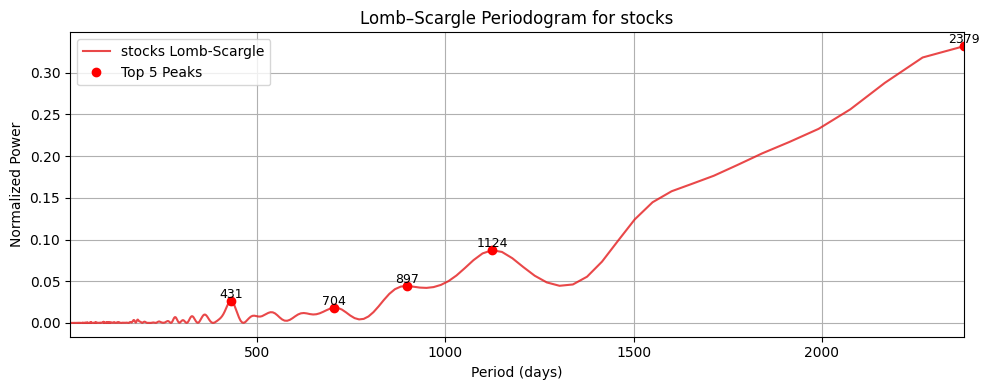

Instrument: sugar
Top 5 highest unique peaks (Period ≥ 2 days):
  Period = 478 days, Power = 0.0139
  Period = 593 days, Power = 0.0283
  Period = 675 days, Power = 0.0402
  Period = 836 days, Power = 0.0557
  Period = 1601 days, Power = 0.1222



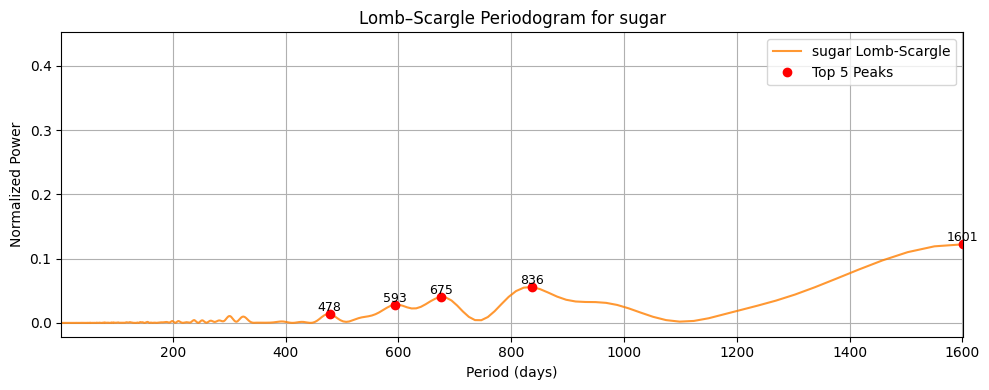

Instrument: water
Top 5 highest unique peaks (Period ≥ 2 days):
  Period = 608 days, Power = 0.0197
  Period = 822 days, Power = 0.0277
  Period = 988 days, Power = 0.0304
  Period = 1237 days, Power = 0.0517
  Period = 1655 days, Power = 0.1840



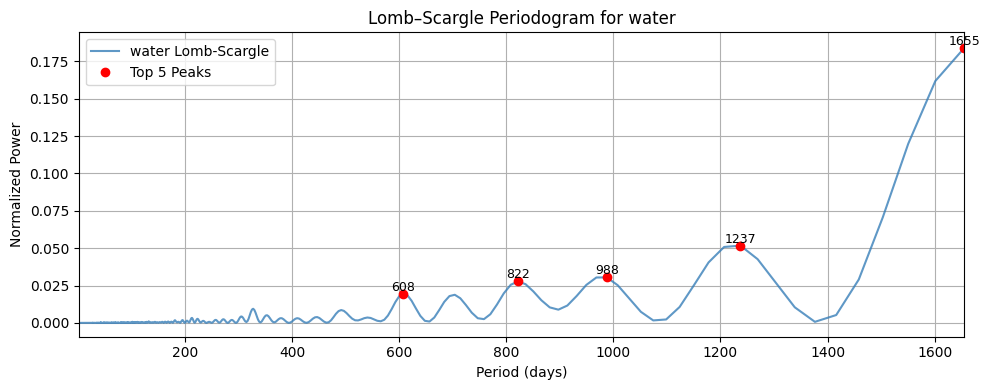

Instrument: tranquillity
Top 5 highest unique peaks (Period ≥ 2 days):
  Period = 451 days, Power = 0.0282
  Period = 535 days, Power = 0.0392
  Period = 932 days, Power = 0.0973
  Period = 1269 days, Power = 0.1145
  Period = 1914 days, Power = 0.0649



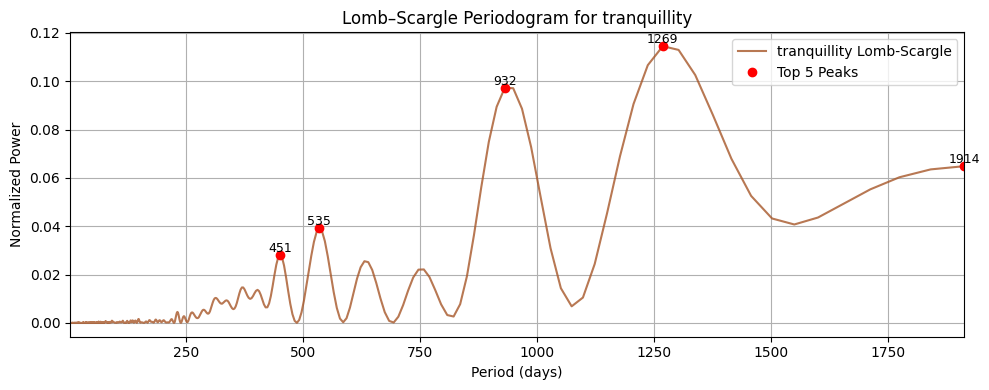

In [15]:
# Define storage dictionaries
periods_to_test = {}
MA_detrended = {}

# Loop over each instrument
for col in df.columns:
    if col == 'day':
        continue

    # Extract the series and assign its plotting color
    series = df[col].dropna()
    color = colours.get(col, 'black')

    # Moving-Average Detrending
    window = optimal_windows[col]
    trend_ma = series.rolling(window, center=True, min_periods=1).mean()
    detrended = (series - trend_ma).dropna()
    MA_detrended[col] = detrended

    # Prepare time and signal vectors
    t = np.arange(len(series))
    y = series.values - np.mean(series.values)

    # Lomb–Scargle Periodogram
    min_p, max_p = 2, 2500  # Period limits in days
    ls = LombScargle(t, y)
    frequency, power = ls.autopower(
        minimum_frequency=1/max_p,
        maximum_frequency=1/min_p,
        samples_per_peak=10
    )
    period = 1.0 / frequency

    # Detect local peaks
    peak_indices, _ = find_peaks(power)
    peak_periods = period[peak_indices]
    peak_powers = power[peak_indices]

    # Sort peaks by descending power
    sorted_indices = np.argsort(peak_powers)[::-1]
    sorted_periods = peak_periods[sorted_indices]
    sorted_powers = peak_powers[sorted_indices]

    # Extract top 5 unique rounded periods (≥2 days)
    unique_peaks = {}
    for p, powr in zip(sorted_periods, sorted_powers):
        rounded_p = int(round(p))
        if rounded_p >= 2 and rounded_p not in unique_peaks:
            unique_peaks[rounded_p] = powr
        if len(unique_peaks) == 5:
            break

    # Final arrays
    top_periods = np.array(list(unique_peaks.keys()))
    top_powers = np.array([unique_peaks[p] for p in top_periods])

    # Save candidate periods
    periods_to_test[col] = set(top_periods)

    # Output the top 5 peaks
    print(f"Instrument: {col}")
    print("Top 5 highest unique peaks (Period ≥ 2 days):")
    for p, powr in sorted(zip(top_periods, top_powers)):
        print(f"  Period = {p} days, Power = {powr:.4f}")
    print()

    # Plot periodogram
    plt.figure(figsize=(10, 4))
    plt.plot(period, power, label=f"{col} Lomb-Scargle", alpha=0.8, color=color)
    plt.plot(top_periods, top_powers, 'ro', label="Top 5 Peaks")
    for p, powr in zip(top_periods, top_powers):
        plt.text(p, powr, str(p), fontsize=9, ha='center', va='bottom')
    plt.xlim(2, max(300, max(top_periods)))
    plt.xlabel("Period (days)")
    plt.ylabel("Normalized Power")
    plt.title(f"Lomb–Scargle Periodogram for {col}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [16]:
# Analyze seasonality on transformed data
for col in df.columns:
    if col == 'day':
        continue
    
    print(f"\nAnalyzing {col}...")
    series = pd.Series(MA_detrended[col]).dropna()
    
    # Get candidate periods for this column
    periods_for_col = list(periods_to_test.get(col, []))
    
    if not periods_for_col:
        print(f"No candidate periods found for {col}. Skipping.")
        continue
    
    # Compute adaptive cutoff for each candidate period
    adaptive_thresholds = adaptive_cutoff(np.array(periods_for_col))
    
    # Store valid periods exceeding their cutoff
    strong_periods = []

    for period, cutoff in zip(periods_for_col, adaptive_thresholds):
        result = best_fixed_period(series, [period])  # Get function output

        # Ensure the correct strength extraction
        if isinstance(result, (list, tuple, np.ndarray)):  
            strength = result[1]  # Extract seasonality strength if it's a tuple
        else:
            strength = result  # Direct assignment if it's a scalar

        # Filter periods based on adaptive cutoff
        if strength >= cutoff:
            strong_periods.append((period, strength, cutoff))

    # Print only periods that passed the cutoff test
    if strong_periods:
        print(f"Strong Seasonality Detected for {col}:")
        for period, strength, cutoff in strong_periods:
            print(f"  Period {period} days — Strength {strength:.3f} (Cutoff {cutoff:.3f})")
    else:
        print(f"No strong seasonality found for {col}.")



Analyzing cucumbers...
Tested Period 608 days: Strength = 0.295
Tested Period 1713 days: Strength = 0.671
Tested Period 1237 days: Strength = 0.576
Tested Period 822 days: Strength = 0.390
Tested Period 988 days: Strength = 0.421
Strong Seasonality Detected for cucumbers:
  Period 1713 days — Strength 0.671 (Cutoff 0.572)
  Period 1237 days — Strength 0.576 (Cutoff 0.556)

Analyzing guitars...
Tested Period 631 days: Strength = 0.303
Tested Period 881 days: Strength = 0.304
Tested Period 1842 days: Strength = 0.800
Tested Period 759 days: Strength = 0.321
Tested Period 541 days: Strength = 0.236
Strong Seasonality Detected for guitars:
  Period 1842 days — Strength 0.800 (Cutoff 0.576)

Analyzing slingshots...
Tested Period 547 days: Strength = 0.270
Tested Period 968 days: Strength = 0.426
Tested Period 714 days: Strength = 0.421
Tested Period 1713 days: Strength = 0.641
Tested Period 1237 days: Strength = 0.583
Strong Seasonality Detected for slingshots:
  Period 1713 days — Strengt

FAP - lvl insted of top 5

<Figure size 800x400 with 0 Axes>

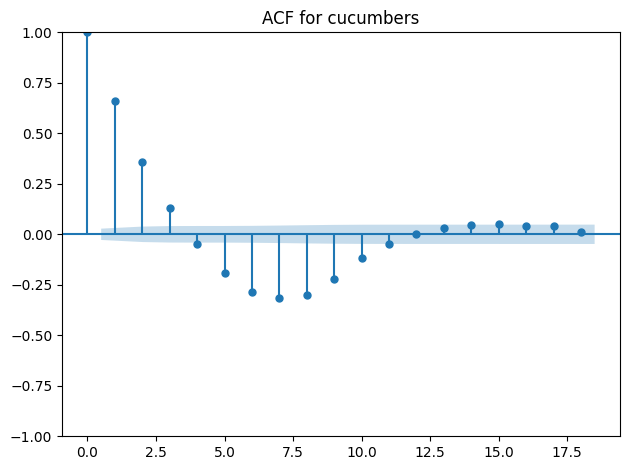

Box–Ljung Test for cucumbers (10 lags):
        lb_stat  lb_pvalue
18  4727.926339        0.0

Instrument: cucumbers
Significant integer periods (no duplicates): [12 13 14 15 16 17 18 19 20 36]
Detailed significant peaks:
  Period = 36.50 days, Power = 0.0068, FAP = 0.00273
  Period = 19.96 days, Power = 0.0101, FAP = 0.00000
  Period = 19.32 days, Power = 0.0070, FAP = 0.00158
  Period = 18.25 days, Power = 0.0078, FAP = 0.00025
  Period = 17.98 days, Power = 0.0082, FAP = 0.00010
  Period = 16.59 days, Power = 0.0069, FAP = 0.00237
  Period = 16.25 days, Power = 0.0071, FAP = 0.00130
  Period = 15.01 days, Power = 0.0069, FAP = 0.00250
  Period = 14.96 days, Power = 0.0091, FAP = 0.00001
  Period = 14.34 days, Power = 0.0100, FAP = 0.00000
  Period = 14.03 days, Power = 0.0110, FAP = 0.00000
  Period = 13.89 days, Power = 0.0136, FAP = 0.00000
  Period = 13.00 days, Power = 0.0093, FAP = 0.00001
  Period = 12.53 days, Power = 0.0064, FAP = 0.00780
  Period = 12.27 days, Power = 0.006

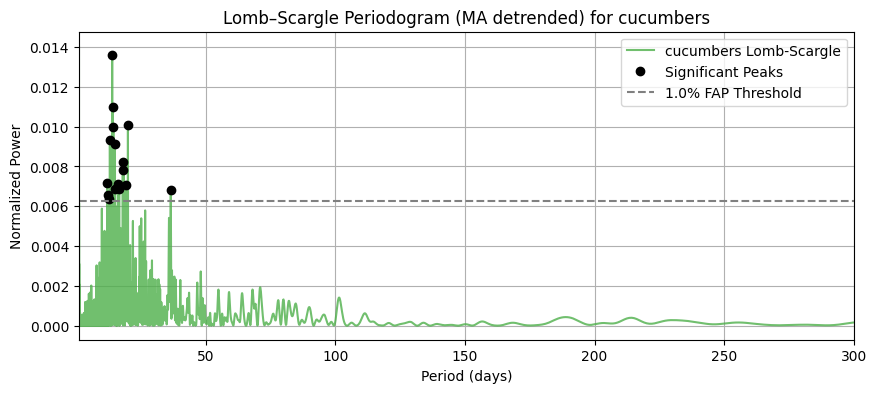

<Figure size 800x400 with 0 Axes>

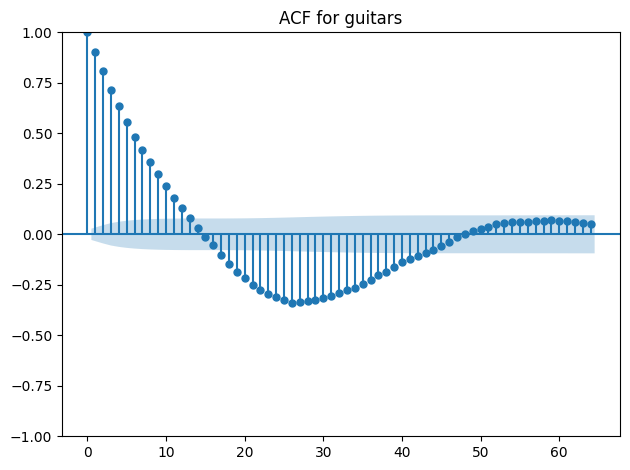

Box–Ljung Test for guitars (10 lags):
         lb_stat  lb_pvalue
64  25403.187259        0.0

Instrument: guitars
Significant integer periods (no duplicates): [ 32  36  43  44  45  46  47  48  51  52  54  55  56  58  59  61  63  64
  66  68  69  71  79  81  83  87  92  95 100 103 107 111 128 153 184]
Detailed significant peaks:
  Period = 183.80 days, Power = 0.0087, FAP = 0.00003
  Period = 153.32 days, Power = 0.0073, FAP = 0.00095
  Period = 128.07 days, Power = 0.0158, FAP = 0.00000
  Period = 110.71 days, Power = 0.0110, FAP = 0.00000
  Period = 107.08 days, Power = 0.0067, FAP = 0.00388
  Period = 103.46 days, Power = 0.0138, FAP = 0.00000
  Period = 99.88 days, Power = 0.0063, FAP = 0.00856
  Period = 95.22 days, Power = 0.0144, FAP = 0.00000
  Period = 92.35 days, Power = 0.0171, FAP = 0.00000
  Period = 86.79 days, Power = 0.0153, FAP = 0.00000
  Period = 83.25 days, Power = 0.0168, FAP = 0.00000
  Period = 81.31 days, Power = 0.0307, FAP = 0.00000
  Period = 79.34 days, Powe

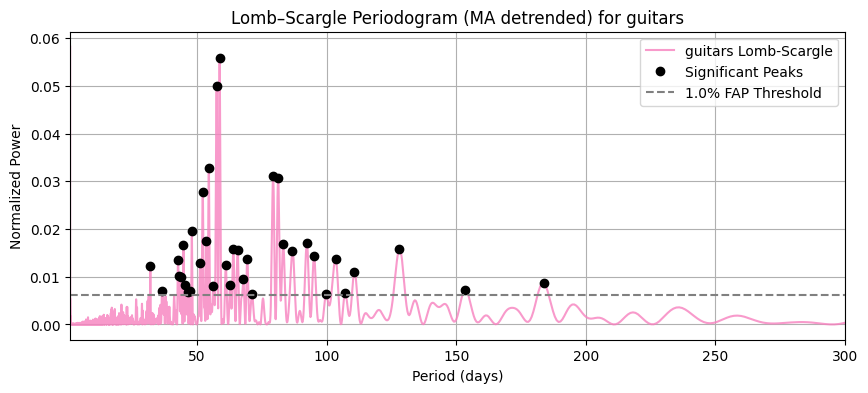

<Figure size 800x400 with 0 Axes>

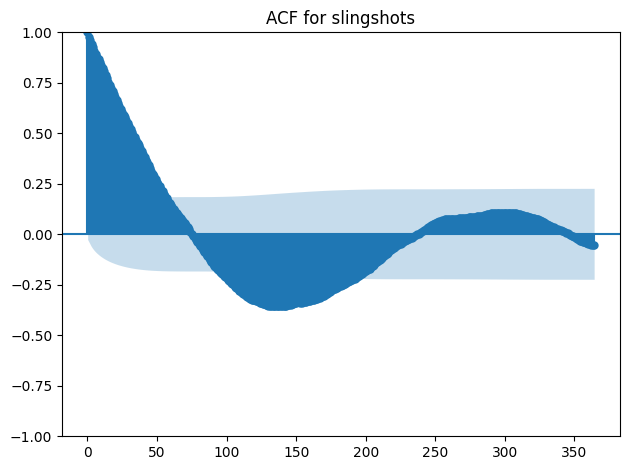

Box–Ljung Test for slingshots (10 lags):
           lb_stat  lb_pvalue
364  158142.004292        0.0

Instrument: slingshots
Significant integer periods (no duplicates): [  75   79   81   96  104  108  115  127  132  140  146  154  169  182
  202  221  237  257  276  311  332  378  420  478  559  666  809 1842]
Detailed significant peaks:
  Period = 1842.11 days, Power = 0.0138, FAP = 0.00000
  Period = 808.58 days, Power = 0.0425, FAP = 0.00000
  Period = 665.76 days, Power = 0.0161, FAP = 0.00000
  Period = 559.36 days, Power = 0.0146, FAP = 0.00000
  Period = 477.58 days, Power = 0.0703, FAP = 0.00000
  Period = 420.24 days, Power = 0.0410, FAP = 0.00000
  Period = 378.09 days, Power = 0.0724, FAP = 0.00000
  Period = 331.98 days, Power = 0.0777, FAP = 0.00000
  Period = 310.91 days, Power = 0.1095, FAP = 0.00000
  Period = 275.90 days, Power = 0.0158, FAP = 0.00000
  Period = 257.08 days, Power = 0.0859, FAP = 0.00000
  Period = 237.17 days, Power = 0.0876, FAP = 0.00000
  Period =

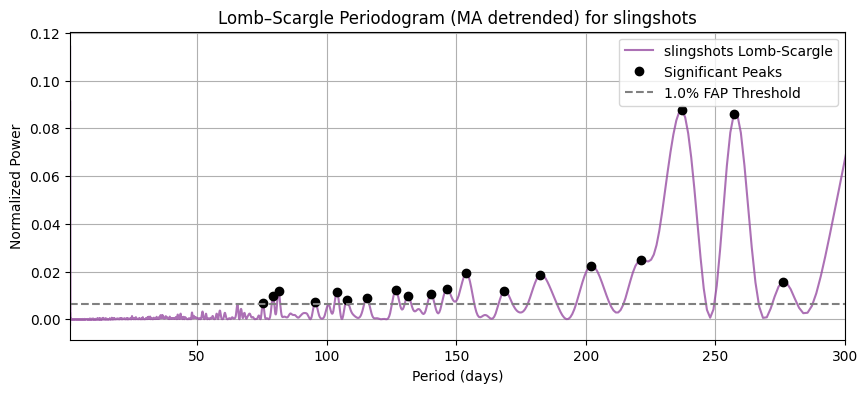

<Figure size 800x400 with 0 Axes>

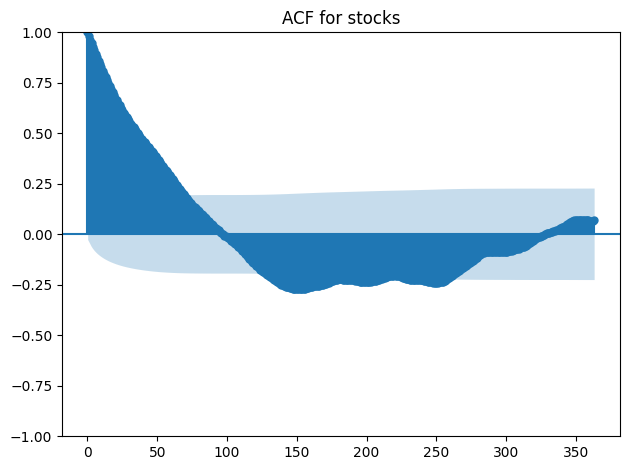

Box–Ljung Test for stocks (10 lags):
          lb_stat  lb_pvalue
363  160406.33814        0.0

Instrument: stocks
Significant integer periods (no duplicates): [  56   57   71   91   94   99  101  106  110  120  128  133  161  172
  182  202  243  260  281  301  328  361  431  492  541  623  704  866
 1029 1503]
Detailed significant peaks:
  Period = 1503.07 days, Power = 0.0077, FAP = 0.00036
  Period = 1029.41 days, Power = 0.0374, FAP = 0.00000
  Period = 865.72 days, Power = 0.0594, FAP = 0.00000
  Period = 704.02 days, Power = 0.0534, FAP = 0.00000
  Period = 623.41 days, Power = 0.0343, FAP = 0.00000
  Period = 540.84 days, Power = 0.0548, FAP = 0.00000
  Period = 491.97 days, Power = 0.0278, FAP = 0.00000
  Period = 431.34 days, Power = 0.1775, FAP = 0.00000
  Period = 361.36 days, Power = 0.0813, FAP = 0.00000
  Period = 327.54 days, Power = 0.0679, FAP = 0.00000
  Period = 301.35 days, Power = 0.0243, FAP = 0.00000
  Period = 280.64 days, Power = 0.0867, FAP = 0.00000
  Period

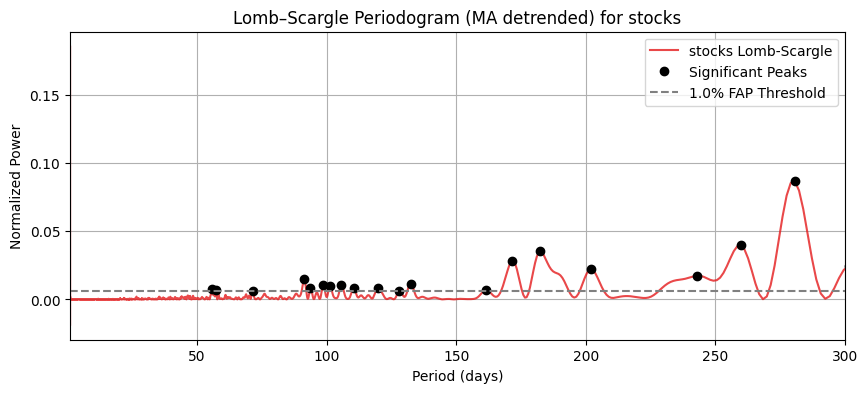

<Figure size 800x400 with 0 Axes>

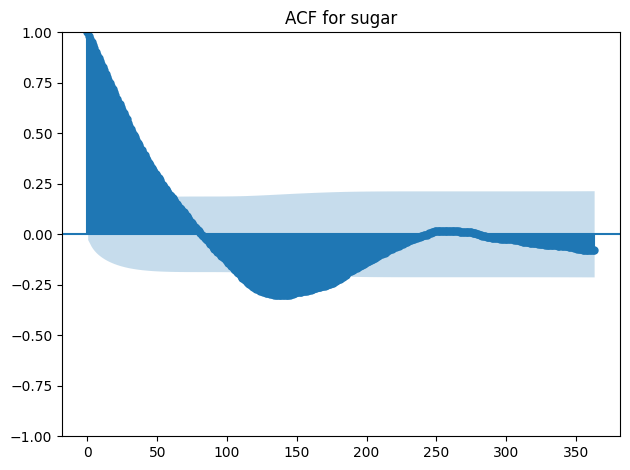

Box–Ljung Test for sugar (10 lags):
           lb_stat  lb_pvalue
363  141375.455002        0.0

Instrument: sugar
Significant integer periods (no duplicates): [  79   86   91   95  100  103  114  117  120  124  136  141  154  188
  198  208  222  236  251  264  281  301  325  354  381  420  468  524
  579  675  851 1713]
Detailed significant peaks:
  Period = 1713.29 days, Power = 0.0127, FAP = 0.00000
  Period = 850.69 days, Power = 0.0658, FAP = 0.00000
  Period = 674.93 days, Power = 0.0596, FAP = 0.00000
  Period = 579.20 days, Power = 0.0634, FAP = 0.00000
  Period = 523.50 days, Power = 0.0352, FAP = 0.00000
  Period = 468.45 days, Power = 0.0640, FAP = 0.00000
  Period = 420.24 days, Power = 0.0135, FAP = 0.00000
  Period = 381.03 days, Power = 0.0410, FAP = 0.00000
  Period = 353.54 days, Power = 0.0088, FAP = 0.00002
  Period = 325.37 days, Power = 0.0807, FAP = 0.00000
  Period = 301.35 days, Power = 0.1370, FAP = 0.00000
  Period = 280.64 days, Power = 0.0348, FAP = 0.00000

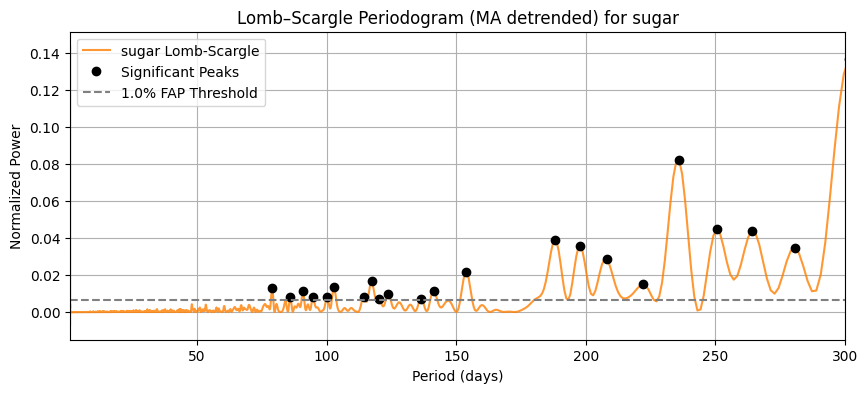

<Figure size 800x400 with 0 Axes>

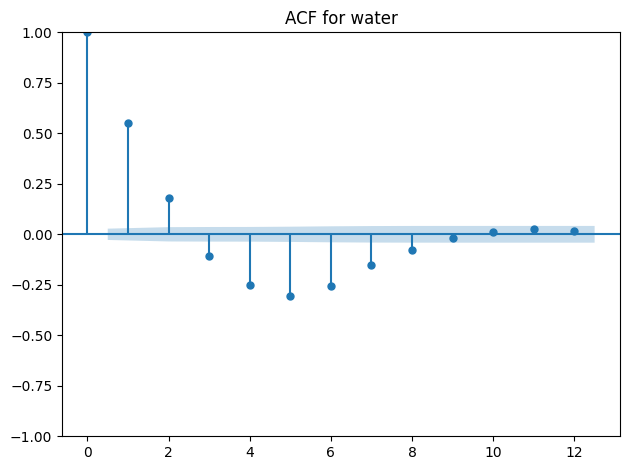

Box–Ljung Test for water (10 lags):
        lb_stat  lb_pvalue
12  2945.049911        0.0

Instrument: water
Significant integer periods (no duplicates): [ 8 10 12 13]
Detailed significant peaks:
  Period = 13.00 days, Power = 0.0085, FAP = 0.00005
  Period = 12.75 days, Power = 0.0065, FAP = 0.00585
  Period = 12.52 days, Power = 0.0063, FAP = 0.00889
  Period = 11.91 days, Power = 0.0068, FAP = 0.00301
  Period = 10.21 days, Power = 0.0086, FAP = 0.00003
  Period = 10.18 days, Power = 0.0081, FAP = 0.00014
  Period = 9.91 days, Power = 0.0076, FAP = 0.00040
  Period = 9.87 days, Power = 0.0080, FAP = 0.00016
  Period = 8.17 days, Power = 0.0064, FAP = 0.00783
  Period = 1.14 days, Power = 0.0066, FAP = 0.00488
  Period = 1.11 days, Power = 0.0083, FAP = 0.00008
  Period = 1.11 days, Power = 0.0079, FAP = 0.00020
  Period = 1.11 days, Power = 0.0084, FAP = 0.00006
  Period = 1.11 days, Power = 0.0090, FAP = 0.00001
  Period = 1.10 days, Power = 0.0065, FAP = 0.00534
  Period = 1.09 da

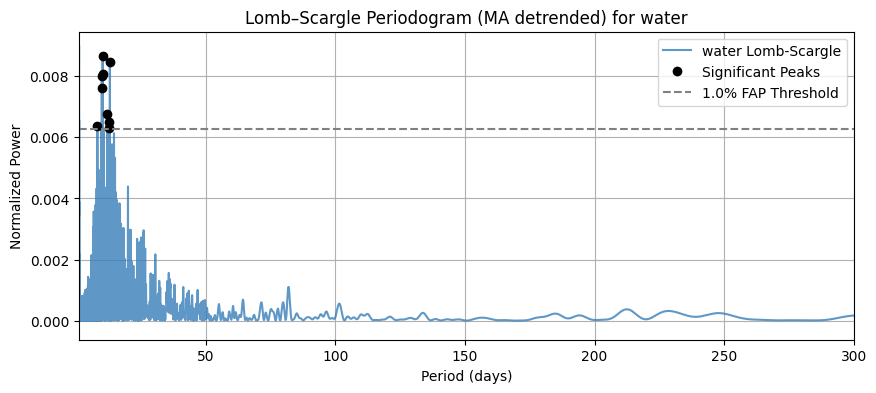

<Figure size 800x400 with 0 Axes>

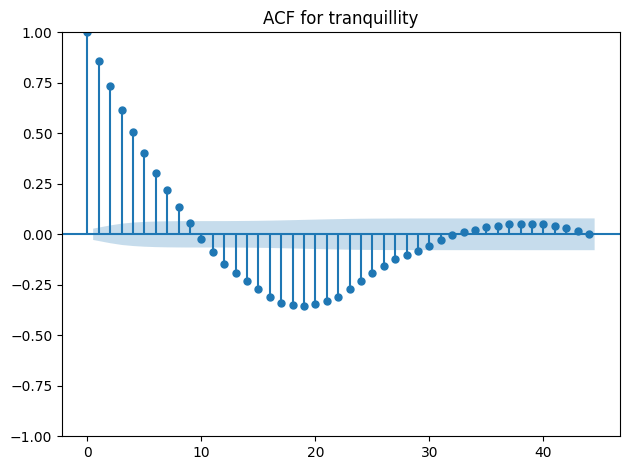

Box–Ljung Test for tranquillity (10 lags):
         lb_stat  lb_pvalue
44  16956.023002        0.0

Instrument: tranquillity
Significant integer periods (no duplicates): [30 31 32 34 35 36 37 38 39 42 45 46 47 48 49 50 51 52 53 55 58 61 63 65
 68 69 71 78 92]
Detailed significant peaks:
  Period = 92.00 days, Power = 0.0078, FAP = 0.00027
  Period = 78.45 days, Power = 0.0085, FAP = 0.00004
  Period = 71.37 days, Power = 0.0094, FAP = 0.00001
  Period = 68.86 days, Power = 0.0088, FAP = 0.00002
  Period = 67.53 days, Power = 0.0111, FAP = 0.00000
  Period = 64.68 days, Power = 0.0070, FAP = 0.00166
  Period = 63.34 days, Power = 0.0175, FAP = 0.00000
  Period = 60.52 days, Power = 0.0070, FAP = 0.00184
  Period = 57.61 days, Power = 0.0105, FAP = 0.00000
  Period = 55.27 days, Power = 0.0063, FAP = 0.00855
  Period = 53.17 days, Power = 0.0072, FAP = 0.00121
  Period = 52.04 days, Power = 0.0082, FAP = 0.00009
  Period = 51.38 days, Power = 0.0068, FAP = 0.00299
  Period = 50.23 days, 

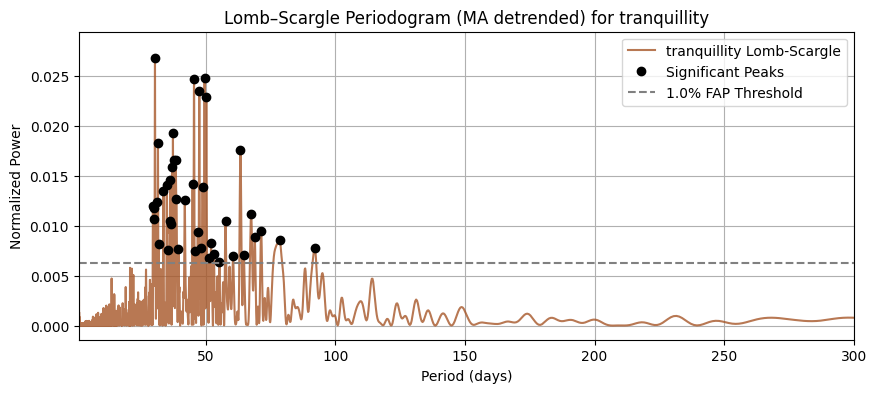

In [17]:
#Lomb Scargle
# Define the significance level for FAP filtering.
alpha = 0.01
periods_to_test = {}

# Loop over each instrument (all columns except 'day')
for col in df.columns:
    if col == 'day':
        continue
    
    # Extract the series and assign its plotting color.
    series = df[col].dropna()
    color = colours.get(col, 'black')
    
    # Moving-Average Detrending
    window = optimal_windows[col]
    trend_ma = series.rolling(window, center=True, min_periods=1).mean()
    detrended = (series - trend_ma).dropna()
    MA_detrended[col] = detrended
    
    # Plot the Autocorrelation Function (ACF)
    plt.figure(figsize=(8, 4))
    plot_acf(detrended, lags=window )
    plt.title(f"ACF for {col}")
    plt.tight_layout()
    plt.show()
    
    # Perform the Box–Ljung test 
    # The test checks the null hypothesis that the series is independently distributed.
    lb_test = acorr_ljungbox(detrended, lags=[window ], return_df=True)
    print(f"Box–Ljung Test for {col} (10 lags):\n{lb_test}\n")
    
    # Numeric time & zero-mean adjustment 
    t = np.arange(len(detrended))
    y = detrended.values
    y -= np.mean(y)

    # Lomb–Scargle Periodogram Calculation
    min_p, max_p = 1, 2500  # period limits in days
    ls = LombScargle(t, y)
    frequency, power = ls.autopower(
        minimum_frequency=1/max_p,
        maximum_frequency=1/min_p,
        samples_per_peak=10
    )
    period = 1.0 / frequency

    # Detect local peaks in the periodogram 
    peak_indices, _ = find_peaks(power)
    peak_freqs = frequency[peak_indices]
    peak_periods = 1.0 / peak_freqs
    peak_powers = power[peak_indices]

    # Compute False Alarm Probability (FAP) for each peak
    peak_faps = ls.false_alarm_probability(peak_powers)

    # Filter peaks by significance level α < 0.01 
    significant = peak_faps < alpha
    sig_periods = peak_periods[significant]
    sig_powers = peak_powers[significant]
    sig_faps = peak_faps[significant]

    # Round significant periods to integers, remove duplicates, and keep only values > 1
    rounded_periods = np.round(sig_periods).astype(int)
    unique_rounded_periods = np.unique(rounded_periods[rounded_periods > 1])

    # Save the candidate periods as a set into the dictionary.
    periods_to_test[col] = set(unique_rounded_periods)
    
    # Output the candidate seasonal periods 
    print(f"Instrument: {col}")
    print("Significant integer periods (no duplicates):", unique_rounded_periods)
    print("Detailed significant peaks:")
    for p, powr, fap in zip(sig_periods, sig_powers, sig_faps):
        print(f"  Period = {p:.2f} days, Power = {powr:.4f}, FAP = {fap:.5f}")
    print("\n")
    
    # Plot periodogram with significant peaks marked as red dots 
    fap_threshold = ls.false_alarm_level(alpha)
    plt.figure(figsize=(10, 4))
    plt.plot(period, power, label=f"{col} Lomb-Scargle", alpha=0.8, color=color)
    # Plot significant peaks as red dots.
    mask = sig_periods > 1.8  # Use a small buffer to avoid floating-point precision issues
    plt.plot(sig_periods[mask], sig_powers[mask], 'ko', label='Significant Peaks')
    plt.axhline(fap_threshold, linestyle="--", color="gray", 
                label=f"{alpha*100:.1f}% FAP Threshold")
    plt.xlim(1, 300)
    plt.xlabel("Period (days)")
    plt.ylabel("Normalized Power")
    plt.title(f"Lomb–Scargle Periodogram (MA detrended) for {col}")
    plt.legend()
    plt.grid(True)
    plt.show()



In [18]:
# Analyze seasonality on transformed data
for col in df.columns:
    if col == 'day':
        continue
    
    print(f"\nAnalyzing {col}...")
    series = pd.Series(MA_detrended[col]).dropna()
    
    # Get candidate periods for this column
    periods_for_col = list(periods_to_test.get(col, []))
    
    if not periods_for_col:
        print(f"No candidate periods found for {col}. Skipping.")
        continue
    
    # Compute adaptive cutoff for each candidate period
    adaptive_thresholds = adaptive_cutoff(np.array(periods_for_col))
    
    # Store valid periods exceeding their cutoff
    strong_periods = []

    for period, cutoff in zip(periods_for_col, adaptive_thresholds):
        result = best_fixed_period(series, [period])  # Get function output

        # Ensure the correct strength extraction
        if isinstance(result, (list, tuple, np.ndarray)):  
            strength = result[1]  # Extract seasonality strength if it's a tuple
        else:
            strength = result  # Direct assignment if it's a scalar

        # Filter periods based on adaptive cutoff
        if strength >= cutoff:
            strong_periods.append((period, strength, cutoff))

    # Print only periods that passed the cutoff test
    if strong_periods:
        print(f"Strong Seasonality Detected for {col}:")
        for period, strength, cutoff in strong_periods:
            print(f"  Period {period} days — Strength {strength:.3f} (Cutoff {cutoff:.3f})")
    else:
        print(f"No strong seasonality found for {col}.")



Analyzing cucumbers...
Tested Period 36 days: Strength = 0.271
Tested Period 12 days: Strength = 0.230
Tested Period 13 days: Strength = 0.268
Tested Period 14 days: Strength = 0.295
Tested Period 15 days: Strength = 0.271
Tested Period 16 days: Strength = 0.264
Tested Period 17 days: Strength = 0.244
Tested Period 18 days: Strength = 0.262
Tested Period 19 days: Strength = 0.259
Tested Period 20 days: Strength = 0.262
No strong seasonality found for cucumbers.

Analyzing guitars...
Tested Period 128 days: Strength = 0.251
Tested Period 153 days: Strength = 0.204
Tested Period 32 days: Strength = 0.187
Tested Period 36 days: Strength = 0.187
Tested Period 43 days: Strength = 0.220
Tested Period 44 days: Strength = 0.221
Tested Period 45 days: Strength = 0.219
Tested Period 46 days: Strength = 0.211
Tested Period 47 days: Strength = 0.211
Tested Period 48 days: Strength = 0.211
Tested Period 51 days: Strength = 0.238
Tested Period 52 days: Strength = 0.247
Tested Period 54 days: Streng

Seasonal strength of Guerrero Box-cox transformed and ma detrended data

In [28]:
# Heuristic-based window selection + detrending
detrended_df = pd.DataFrame(index=df_boxcox_guerrero.index)
optimal_windows = {}

# Apply to each transformed series
for col in df.columns:
    if col == 'day':
        continue
    print(f"Detrending {col}...")
    series = df_boxcox_guerrero[col].dropna()
    window_range = range(5, 365, 1)
 
    best_w, score_table = compute_optimal_window(series, window_range)
    if best_w is None:
        print(f"No valid window found for {col}.")
        continue
 
    trend = series.rolling(window=best_w, center=True, min_periods=1).mean()
    detrended = (series - trend).dropna()
 
    detrended_df[col] = detrended
    optimal_windows[col] = best_w
    print(f"Best window size for {col}: {best_w}")

Detrending cucumbers...
Best window size for cucumbers: 16
Detrending guitars...
Best window size for guitars: 363
Detrending slingshots...
Best window size for slingshots: 363
Detrending stocks...
Best window size for stocks: 363
Detrending sugar...
Best window size for sugar: 363
Detrending water...
Best window size for water: 10
Detrending tranquillity...
Best window size for tranquillity: 78


Instrument: cucumbers
Top 5 highest unique peaks (Period ≥ 2 days):
  Period = 608 days, Power = 0.0132
  Period = 822 days, Power = 0.0201
  Period = 988 days, Power = 0.0320
  Period = 1237 days, Power = 0.0462
  Period = 1713 days, Power = 0.0922



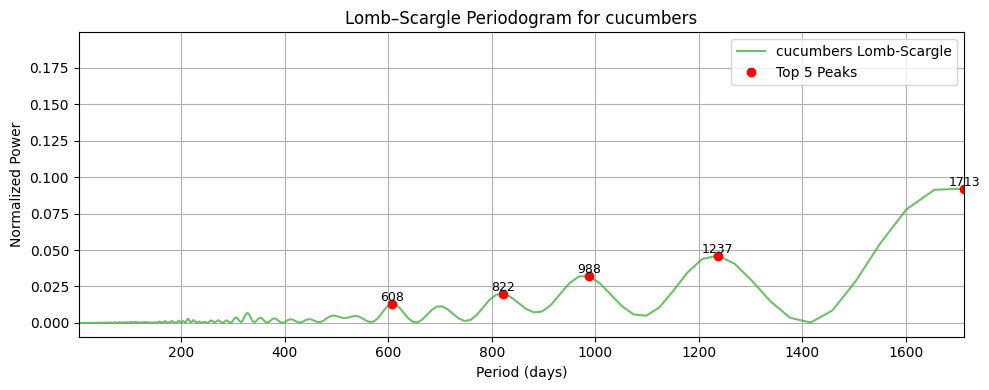

Instrument: guitars
Top 5 highest unique peaks (Period ≥ 2 days):
  Period = 541 days, Power = 0.0212
  Period = 631 days, Power = 0.0297
  Period = 759 days, Power = 0.0195
  Period = 881 days, Power = 0.0448
  Period = 1842 days, Power = 0.5279



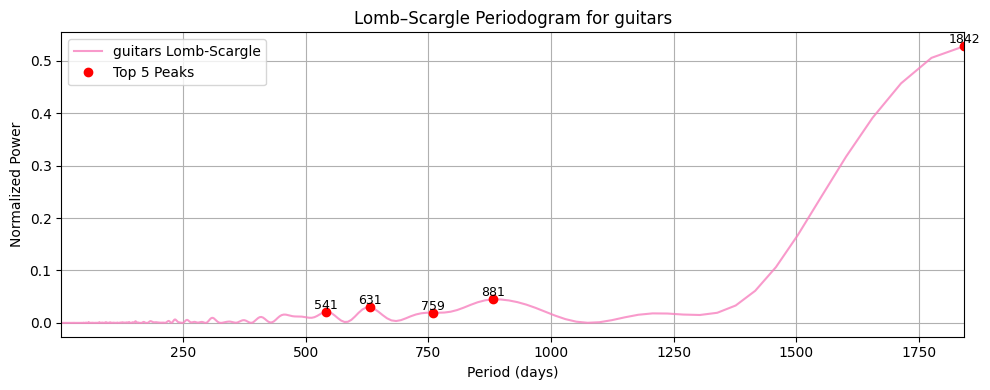

Instrument: slingshots
Top 5 highest unique peaks (Period ≥ 2 days):
  Period = 547 days, Power = 0.0217
  Period = 714 days, Power = 0.0271
  Period = 968 days, Power = 0.0346
  Period = 1237 days, Power = 0.0855
  Period = 1713 days, Power = 0.3489



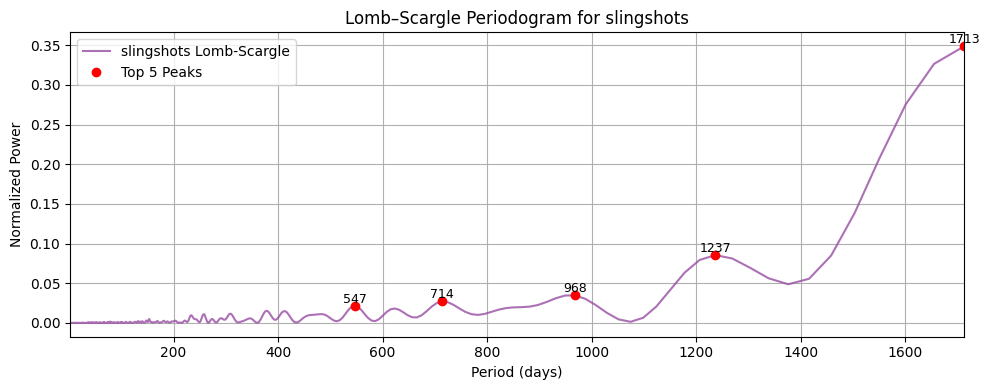

Instrument: stocks
Top 5 highest unique peaks (Period ≥ 2 days):
  Period = 431 days, Power = 0.0259
  Period = 704 days, Power = 0.0183
  Period = 897 days, Power = 0.0443
  Period = 1124 days, Power = 0.0872
  Period = 2379 days, Power = 0.3319



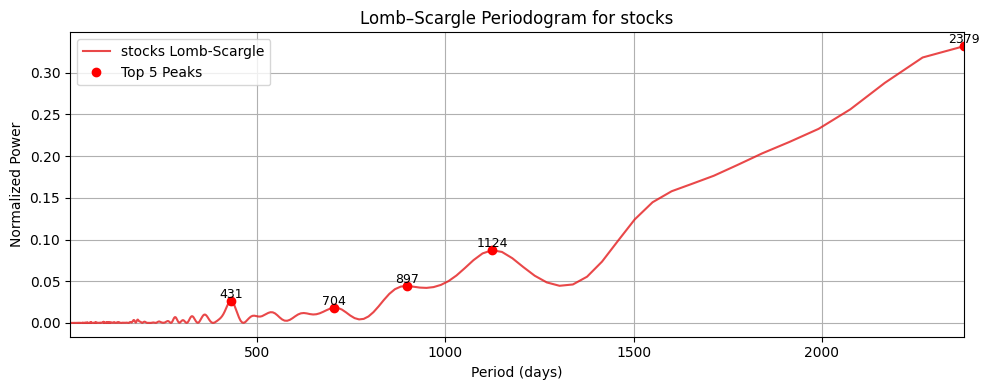

Instrument: sugar
Top 5 highest unique peaks (Period ≥ 2 days):
  Period = 478 days, Power = 0.0139
  Period = 593 days, Power = 0.0283
  Period = 675 days, Power = 0.0402
  Period = 836 days, Power = 0.0557
  Period = 1601 days, Power = 0.1222



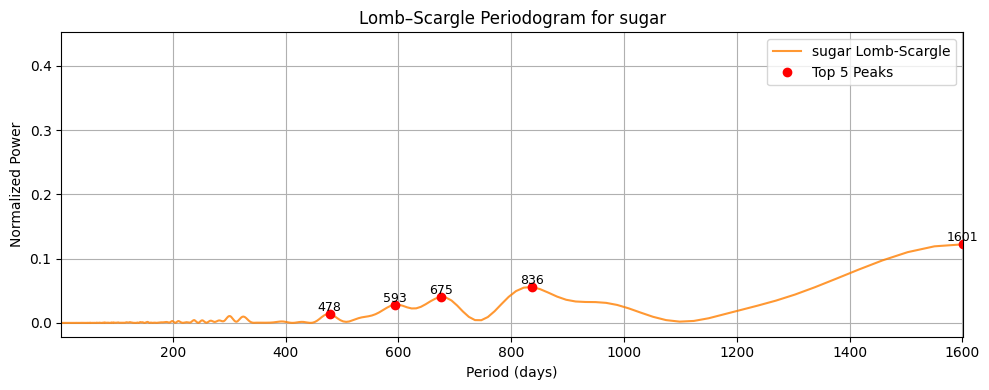

Instrument: water
Top 5 highest unique peaks (Period ≥ 2 days):
  Period = 608 days, Power = 0.0197
  Period = 822 days, Power = 0.0277
  Period = 988 days, Power = 0.0304
  Period = 1237 days, Power = 0.0517
  Period = 1655 days, Power = 0.1840



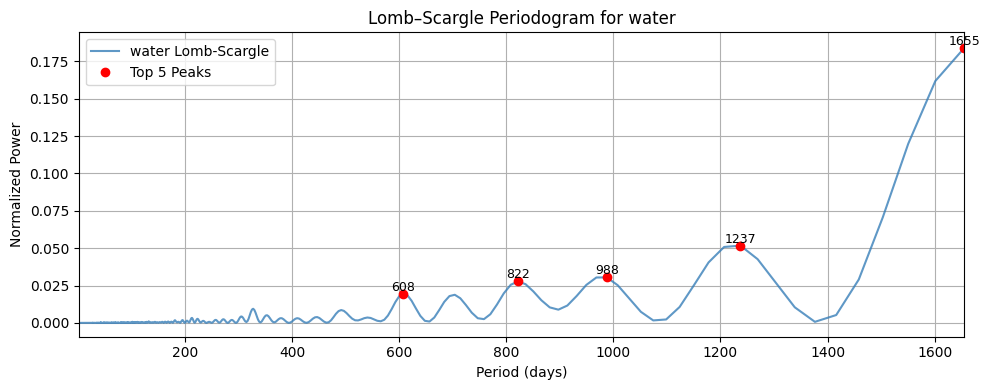

Instrument: tranquillity
Top 5 highest unique peaks (Period ≥ 2 days):
  Period = 451 days, Power = 0.0282
  Period = 535 days, Power = 0.0392
  Period = 932 days, Power = 0.0973
  Period = 1269 days, Power = 0.1145
  Period = 1914 days, Power = 0.0649



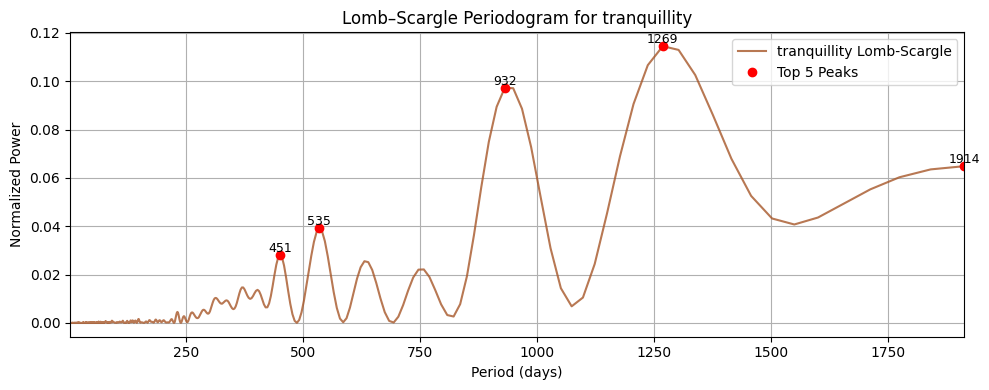

In [ ]:
# Define storage dictionaries
periods_to_test = {}
MA_detrended = {}

# Loop over each instrument
for col in df.columns:
    if col == 'day':
        continue

    # Extract the series and assign its plotting color
    series = df_boxcox_guerrero[col].dropna()
    color = colours.get(col, 'black')

    # Moving-Average Detrending
    window = optimal_windows[col]
    trend_ma = series.rolling(window, center=True, min_periods=1).mean()
    detrended = (series - trend_ma).dropna()
    MA_detrended[col] = detrended

    # Prepare time and signal vectors
    t = np.arange(len(series))
    y = series.values - np.mean(series.values)

    # Lomb–Scargle Periodogram
    min_p, max_p = 2, 2500  # Period limits in days
    ls = LombScargle(t, y)
    frequency, power = ls.autopower(
        minimum_frequency=1/max_p,
        maximum_frequency=1/min_p,
        samples_per_peak=10
    )
    period = 1.0 / frequency

    # Detect local peaks
    peak_indices, _ = find_peaks(power)
    peak_periods = period[peak_indices]
    peak_powers = power[peak_indices]

    # Sort peaks by descending power
    sorted_indices = np.argsort(peak_powers)[::-1]
    sorted_periods = peak_periods[sorted_indices]
    sorted_powers = peak_powers[sorted_indices]

    # Extract top 5 unique rounded periods (≥2 days)
    unique_peaks = {}
    for p, powr in zip(sorted_periods, sorted_powers):
        rounded_p = int(round(p))
        if rounded_p >= 2 and rounded_p not in unique_peaks:
            unique_peaks[rounded_p] = powr
        if len(unique_peaks) == 5:
            break

    # Final arrays
    top_periods = np.array(list(unique_peaks.keys()))
    top_powers = np.array([unique_peaks[p] for p in top_periods])

    # Save candidate periods
    periods_to_test[col] = set(top_periods)

    # Output the top 5 peaks
    print(f"Instrument: {col}")
    print("Top 5 highest unique peaks (Period ≥ 2 days):")
    for p, powr in sorted(zip(top_periods, top_powers)):
        print(f"  Period = {p} days, Power = {powr:.4f}")
    print()

    # Plot periodogram
    plt.figure(figsize=(10, 4))
    plt.plot(period, power, label=f"{col} Lomb-Scargle", alpha=0.8, color=color)
    plt.plot(top_periods, top_powers, 'ro', label="Top 5 Peaks")
    for p, powr in zip(top_periods, top_powers):
        plt.text(p, powr, str(p), fontsize=9, ha='center', va='bottom')
    plt.xlim(2, max(300, max(top_periods)))
    plt.xlabel("Period (days)")
    plt.ylabel("Normalized Power")
    plt.title(f"Lomb–Scargle Periodogram for {col}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [29]:
# Analyze seasonality on transformed data
for col in df.columns:
    if col == 'day':
        continue
    
    print(f"\nAnalyzing {col}...")
    series = pd.Series(MA_detrended[col]).dropna()
    
    # Get candidate periods for this column
    periods_for_col = list(periods_to_test.get(col, []))
    
    if not periods_for_col:
        print(f"No candidate periods found for {col}. Skipping.")
        continue
    
    # Compute adaptive cutoff for each candidate period
    adaptive_thresholds = adaptive_cutoff(np.array(periods_for_col))
    
    # Store valid periods exceeding their cutoff
    strong_periods = []

    for period, cutoff in zip(periods_for_col, adaptive_thresholds):
        result = best_fixed_period(series, [period])  # Get function output

        # Ensure the correct strength extraction
        if isinstance(result, (list, tuple, np.ndarray)):  
            strength = result[1]  # Extract seasonality strength if it's a tuple
        else:
            strength = result  # Direct assignment if it's a scalar

        # Filter periods based on adaptive cutoff
        if strength >= cutoff:
            strong_periods.append((period, strength, cutoff))

    # Print only periods that passed the cutoff test
    if strong_periods:
        print(f"Strong Seasonality Detected for {col}:")
        for period, strength, cutoff in strong_periods:
            print(f"  Period {period} days — Strength {strength:.3f} (Cutoff {cutoff:.3f})")
    else:
        print(f"No strong seasonality found for {col}.")



Analyzing cucumbers...
Tested Period 608 days: Strength = 0.295
Tested Period 1713 days: Strength = 0.676
Tested Period 1237 days: Strength = 0.577
Tested Period 822 days: Strength = 0.390
Tested Period 988 days: Strength = 0.420
Strong Seasonality Detected for cucumbers:
  Period 1713 days — Strength 0.676 (Cutoff 0.572)
  Period 1237 days — Strength 0.577 (Cutoff 0.556)

Analyzing guitars...
Tested Period 631 days: Strength = 0.247
Tested Period 881 days: Strength = 0.277
Tested Period 1842 days: Strength = 0.788
Tested Period 759 days: Strength = 0.280
Tested Period 541 days: Strength = 0.230
Strong Seasonality Detected for guitars:
  Period 1842 days — Strength 0.788 (Cutoff 0.576)

Analyzing slingshots...
Tested Period 547 days: Strength = 0.270
Tested Period 968 days: Strength = 0.426
Tested Period 714 days: Strength = 0.421
Tested Period 1713 days: Strength = 0.641
Tested Period 1237 days: Strength = 0.583
Strong Seasonality Detected for slingshots:
  Period 1713 days — Strengt

FAP - lvl insted of top 5

In [ ]:
#Lomb Scargle
# Define the significance level for FAP filtering.
alpha = 0.01
periods_to_test = {}

# Loop over each instrument (all columns except 'day')
for col in df.columns:
    if col == 'day':
        continue
    
    # Extract the series and assign its plotting color.
    series = df_boxcox_mle[col].dropna()
    color = colours.get(col, 'black')
    
    # Moving-Average Detrending
    window = optimal_windows[col]
    trend_ma = series.rolling(window, center=True, min_periods=1).mean()
    detrended = (series - trend_ma).dropna()
    MA_detrended[col] = detrended
    
    # Plot the Autocorrelation Function (ACF)
    plt.figure(figsize=(8, 4))
    plot_acf(detrended, lags=window )
    plt.title(f"ACF for {col}")
    plt.tight_layout()
    plt.show()
    
    # Perform the Box–Ljung test 
    # The test checks the null hypothesis that the series is independently distributed.
    lb_test = acorr_ljungbox(detrended, lags=[window ], return_df=True)
    print(f"Box–Ljung Test for {col} (10 lags):\n{lb_test}\n")
    
    # Numeric time & zero-mean adjustment 
    t = np.arange(len(detrended))
    y = detrended.values
    y -= np.mean(y)

    # Lomb–Scargle Periodogram Calculation
    min_p, max_p = 1, 2500  # period limits in days
    ls = LombScargle(t, y)
    frequency, power = ls.autopower(
        minimum_frequency=1/max_p,
        maximum_frequency=1/min_p,
        samples_per_peak=10
    )
    period = 1.0 / frequency

    # Detect local peaks in the periodogram 
    peak_indices, _ = find_peaks(power)
    peak_freqs = frequency[peak_indices]
    peak_periods = 1.0 / peak_freqs
    peak_powers = power[peak_indices]

    # Compute False Alarm Probability (FAP) for each peak
    peak_faps = ls.false_alarm_probability(peak_powers)

    # Filter peaks by significance level α < 0.01 
    significant = peak_faps < alpha
    sig_periods = peak_periods[significant]
    sig_powers = peak_powers[significant]
    sig_faps = peak_faps[significant]

    # Round significant periods to integers, remove duplicates, and keep only values > 1
    rounded_periods = np.round(sig_periods).astype(int)
    unique_rounded_periods = np.unique(rounded_periods[rounded_periods > 1])

    # Save the candidate periods as a set into the dictionary.
    periods_to_test[col] = set(unique_rounded_periods)
    
    # Output the candidate seasonal periods 
    print(f"Instrument: {col}")
    print("Significant integer periods (no duplicates):", unique_rounded_periods)
    print("Detailed significant peaks:")
    for p, powr, fap in zip(sig_periods, sig_powers, sig_faps):
        print(f"  Period = {p:.2f} days, Power = {powr:.4f}, FAP = {fap:.5f}")
    print("\n")
    
    # Plot periodogram with significant peaks marked as red dots 
    fap_threshold = ls.false_alarm_level(alpha)
    plt.figure(figsize=(10, 4))
    plt.plot(period, power, label=f"{col} Lomb-Scargle", alpha=0.8, color=color)
    # Plot significant peaks as red dots.
    mask = sig_periods > 1.8  # Use a small buffer to avoid floating-point precision issues
    plt.plot(sig_periods[mask], sig_powers[mask], 'ko', label='Significant Peaks')
    plt.axhline(fap_threshold, linestyle="--", color="gray", 
                label=f"{alpha*100:.1f}% FAP Threshold")
    plt.xlim(1, 300)
    plt.xlabel("Period (days)")
    plt.ylabel("Normalized Power")
    plt.title(f"Lomb–Scargle Periodogram (MA detrended) for {col}")
    plt.legend()
    plt.grid(True)
    plt.show()



In [ ]:
# Analyze seasonality on transformed data
for col in df.columns:
    if col == 'day':
        continue
    
    print(f"\nAnalyzing {col}...")
    series = pd.Series(MA_detrended[col]).dropna()
    
    # Get candidate periods for this column
    periods_for_col = list(periods_to_test.get(col, []))
    
    if not periods_for_col:
        print(f"No candidate periods found for {col}. Skipping.")
        continue
    
    # Compute adaptive cutoff for each candidate period
    adaptive_thresholds = adaptive_cutoff(np.array(periods_for_col))
    
    # Store valid periods exceeding their cutoff
    strong_periods = []

    for period, cutoff in zip(periods_for_col, adaptive_thresholds):
        result = best_fixed_period(series, [period])  # Get function output

        # Ensure the correct strength extraction
        if isinstance(result, (list, tuple, np.ndarray)):  
            strength = result[1]  # Extract seasonality strength if it's a tuple
        else:
            strength = result  # Direct assignment if it's a scalar

        # Filter periods based on adaptive cutoff
        if strength >= cutoff:
            strong_periods.append((period, strength, cutoff))

    # Print only periods that passed the cutoff test
    if strong_periods:
        print(f"Strong Seasonality Detected for {col}:")
        for period, strength, cutoff in strong_periods:
            print(f"  Period {period} days — Strength {strength:.3f} (Cutoff {cutoff:.3f})")
    else:
        print(f"No strong seasonality found for {col}.")


Seasonal strength of mle Box-cox transformed and ma detrended data

In [ ]:
# Heuristic-based window selection + detrending
detrended_df = pd.DataFrame(index=df_boxcox_mle.index)
optimal_windows = {}
 
# Apply to each transformed series
for col in df.columns:
    if col == 'day':
        continue
    print(f"Detrending {col}...")
    series = df_boxcox_mle[col].dropna()
    window_range = range(5, 365, 1)
 
    best_w, score_table = compute_optimal_window(series, window_range)
    if best_w is None:
        print(f"No valid window found for {col}.")
        continue
 
    trend = series.rolling(window=best_w, center=True, min_periods=1).mean()
    detrended = (series - trend).dropna()
 
    detrended_df[col] = detrended
    optimal_windows[col] = best_w
    print(f"Best window size for {col}: {best_w}")

In [ ]:
# Define storage dictionaries
periods_to_test = {}
MA_detrended = {}

# Loop over each instrument
for col in df.columns:
    if col == 'day':
        continue

    # Extract the series and assign its plotting color
    series = df_boxcox_mle[col].dropna()
    color = colours.get(col, 'black')

    # Moving-Average Detrending
    window = optimal_windows[col]
    trend_ma = series.rolling(window, center=True, min_periods=1).mean()
    detrended = (series - trend_ma).dropna()
    MA_detrended[col] = detrended

    # Prepare time and signal vectors
    t = np.arange(len(series))
    y = series.values - np.mean(series.values)

    # Lomb–Scargle Periodogram
    min_p, max_p = 2, 2500  # Period limits in days
    ls = LombScargle(t, y)
    frequency, power = ls.autopower(
        minimum_frequency=1/max_p,
        maximum_frequency=1/min_p,
        samples_per_peak=10
    )
    period = 1.0 / frequency

    # Detect local peaks
    peak_indices, _ = find_peaks(power)
    peak_periods = period[peak_indices]
    peak_powers = power[peak_indices]

    # Sort peaks by descending power
    sorted_indices = np.argsort(peak_powers)[::-1]
    sorted_periods = peak_periods[sorted_indices]
    sorted_powers = peak_powers[sorted_indices]

    # Extract top 5 unique rounded periods (≥2 days)
    unique_peaks = {}
    for p, powr in zip(sorted_periods, sorted_powers):
        rounded_p = int(round(p))
        if rounded_p >= 2 and rounded_p not in unique_peaks:
            unique_peaks[rounded_p] = powr
        if len(unique_peaks) == 5:
            break

    # Final arrays
    top_periods = np.array(list(unique_peaks.keys()))
    top_powers = np.array([unique_peaks[p] for p in top_periods])

    # Save candidate periods
    periods_to_test[col] = set(top_periods)

    # Output the top 5 peaks
    print(f"Instrument: {col}")
    print("Top 5 highest unique peaks (Period ≥ 2 days):")
    for p, powr in sorted(zip(top_periods, top_powers)):
        print(f"  Period = {p} days, Power = {powr:.4f}")
    print()

    # Plot periodogram
    plt.figure(figsize=(10, 4))
    plt.plot(period, power, label=f"{col} Lomb-Scargle", alpha=0.8, color=color)
    plt.plot(top_periods, top_powers, 'ro', label="Top 5 Peaks")
    for p, powr in zip(top_periods, top_powers):
        plt.text(p, powr, str(p), fontsize=9, ha='center', va='bottom')
    plt.xlim(2, max(300, max(top_periods)))
    plt.xlabel("Period (days)")
    plt.ylabel("Normalized Power")
    plt.title(f"Lomb–Scargle Periodogram for {col}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
strong_periods = {}  # Dictionary instead of list

# Analyze seasonality on transformed data
for col in df.columns:
    if col == 'day':
        continue
    
    print(f"\nAnalyzing {col}...")
    series = pd.Series(MA_detrended[col]).dropna()
    
    # Get candidate periods for this column
    periods_for_col = list(periods_to_test.get(col, []))
    
    if not periods_for_col:
        print(f"No candidate periods found for {col}. Skipping.")
        continue
    
    # Compute adaptive cutoff for each candidate period
    adaptive_thresholds = adaptive_cutoff(np.array(periods_for_col))

    # Ensure dictionary entry exists before appending
    if col not in strong_periods:
        strong_periods[col] = []

    for period, cutoff in zip(periods_for_col, adaptive_thresholds):
        result = best_fixed_period(series, [period])  # Get function output

        # Ensure proper strength extraction
        if isinstance(result, (list, tuple, np.ndarray)):  
            strength = result[1]  # Extract seasonality strength if it's a tuple
        else:
            strength = result  # Direct assignment if it's a scalar

        # Filter periods based on adaptive cutoff
        if strength >= cutoff:
            strong_periods[col].append((period, strength, cutoff))

    # Print only periods that passed the cutoff test
    if strong_periods[col]:  # Check column-specific entry, not entire dict
        print(f"Strong Seasonality Detected for {col}:")
        for period, strength, cutoff in strong_periods[col]:
            print(f"  Period {period} days — Strength {strength:.3f} (Cutoff {cutoff:.3f})")
    else:
        print(f"No strong seasonality found for {col}.")


FAP - lvl insted of top 5

In [ ]:
#Lomb Scargle
# Define the significance level for FAP filtering.
alpha = 0.01
periods_to_test = {}

# Loop over each instrument (all columns except 'day')
for col in df.columns:
    if col == 'day':
        continue
    
    # Extract the series and assign its plotting color.
    series = df[col].dropna()
    color = colours.get(col, 'black')
    
    # Moving-Average Detrending
    window = optimal_windows[col]
    trend_ma = series.rolling(window, center=True, min_periods=1).mean()
    detrended = (series - trend_ma).dropna()
    MA_detrended[col] = detrended
    
    # Plot the Autocorrelation Function (ACF)
    plt.figure(figsize=(8, 4))
    plot_acf(detrended, lags=window )
    plt.title(f"ACF for {col}")
    plt.tight_layout()
    plt.show()
    
    # Perform the Box–Ljung test 
    # The test checks the null hypothesis that the series is independently distributed.
    lb_test = acorr_ljungbox(detrended, lags=[window ], return_df=True)
    print(f"Box–Ljung Test for {col} (10 lags):\n{lb_test}\n")
    
    # Numeric time & zero-mean adjustment 
    t = np.arange(len(detrended))
    y = detrended.values
    y -= np.mean(y)

    # Lomb–Scargle Periodogram Calculation
    min_p, max_p = 1, 2500  # period limits in days
    ls = LombScargle(t, y)
    frequency, power = ls.autopower(
        minimum_frequency=1/max_p,
        maximum_frequency=1/min_p,
        samples_per_peak=10
    )
    period = 1.0 / frequency

    # Detect local peaks in the periodogram 
    peak_indices, _ = find_peaks(power)
    peak_freqs = frequency[peak_indices]
    peak_periods = 1.0 / peak_freqs
    peak_powers = power[peak_indices]

    # Compute False Alarm Probability (FAP) for each peak
    peak_faps = ls.false_alarm_probability(peak_powers)

    # Filter peaks by significance level α < 0.01 
    significant = peak_faps < alpha
    sig_periods = peak_periods[significant]
    sig_powers = peak_powers[significant]
    sig_faps = peak_faps[significant]

    # Round significant periods to integers, remove duplicates, and keep only values > 1
    rounded_periods = np.round(sig_periods).astype(int)
    unique_rounded_periods = np.unique(rounded_periods[rounded_periods > 1])

    # Save the candidate periods as a set into the dictionary.
    periods_to_test[col] = set(unique_rounded_periods)
    
    # Output the candidate seasonal periods 
    print(f"Instrument: {col}")
    print("Significant integer periods (no duplicates):", unique_rounded_periods)
    print("Detailed significant peaks:")
    for p, powr, fap in zip(sig_periods, sig_powers, sig_faps):
        print(f"  Period = {p:.2f} days, Power = {powr:.4f}, FAP = {fap:.5f}")
    print("\n")
    
    # Plot periodogram with significant peaks marked as red dots 
    fap_threshold = ls.false_alarm_level(alpha)
    plt.figure(figsize=(10, 4))
    plt.plot(period, power, label=f"{col} Lomb-Scargle", alpha=0.8, color=color)
    # Plot significant peaks as red dots.
    mask = sig_periods > 1.8  # Use a small buffer to avoid floating-point precision issues
    plt.plot(sig_periods[mask], sig_powers[mask], 'ko', label='Significant Peaks')
    plt.axhline(fap_threshold, linestyle="--", color="gray", 
                label=f"{alpha*100:.1f}% FAP Threshold")
    plt.xlim(1, 300)
    plt.xlabel("Period (days)")
    plt.ylabel("Normalized Power")
    plt.title(f"Lomb–Scargle Periodogram (MA detrended) for {col}")
    plt.legend()
    plt.grid(True)
    plt.show()



In [ ]:
strong_periods = {}  # Dictionary instead of list

# Analyze seasonality on transformed data
for col in df.columns:
    if col == 'day':
        continue
    
    print(f"\nAnalyzing {col}...")
    series = pd.Series(MA_detrended[col]).dropna()
    
    # Get candidate periods for this column
    periods_for_col = list(periods_to_test.get(col, []))
    
    if not periods_for_col:
        print(f"No candidate periods found for {col}. Skipping.")
        continue
    
    # Compute adaptive cutoff for each candidate period
    adaptive_thresholds = adaptive_cutoff(np.array(periods_for_col))

    # Ensure dictionary entry exists before appending
    if col not in strong_periods:
        strong_periods[col] = []

    for period, cutoff in zip(periods_for_col, adaptive_thresholds):
        result = best_fixed_period(series, [period])  # Get function output

        # Ensure proper strength extraction
        if isinstance(result, (list, tuple, np.ndarray)):  
            strength = result[1]  # Extract seasonality strength if it's a tuple
        else:
            strength = result  # Direct assignment if it's a scalar

        # Filter periods based on adaptive cutoff
        if strength >= cutoff:
            strong_periods[col].append((period, strength, cutoff))

    # Print only periods that passed the cutoff test
    if strong_periods[col]:  # Check column-specific entry, not entire dict
        print(f"Strong Seasonality Detected for {col}:")
        for period, strength, cutoff in strong_periods[col]:
            print(f"  Period {period} days — Strength {strength:.3f} (Cutoff {cutoff:.3f})")
    else:
        print(f"No strong seasonality found for {col}.")
